In [1]:
# ======================== Imports ========================
import re, unicodedata
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchtext.vocab import build_vocab_from_iterator
import torch.optim as optim
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm

# ======================== Config ========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.backends.cudnn.benchmark = torch.cuda.is_available()

import unicodedata
import re

# ======================== Preprocessing ========================
def custom_preprocess(text, language):
    text = unicodedata.normalize('NFKC', text)  # Unicode normalization
    
    if language == 'de':  # Normalize German-specific characters
        translation_map = str.maketrans({"ä": "ae", "ö": "oe", "ü": "ue", "Ä": "Ae", "Ö": "Oe", "Ü": "Ue", "ß": "ss"})
        text = text.translate(translation_map)

    text = re.sub(r"[^a-zA-Z0-9.,!?\"'\-:;() ]", " ", text)  # Keep relevant characters
    text = text.replace("’", "'").replace("“", "\"").replace("”", "\"")  # Normalize quotes
    text = re.sub(r"([.,!?;:\-()])", r" \1 ", text)  # Separate punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Clean multiple spaces
    
    return f"<start> {text} <end>"  # Add start/end tokens

# ======================== Vocabulary ========================
def build_vocab(texts):
    def word_iterator():
        for text in texts:
            yield text.split()  # Each yield is a list of words

    vocab = build_vocab_from_iterator(word_iterator(), min_freq=0, specials=['<pad>', '<unk>', '<start>', '<end>'])
    vocab.set_default_index(vocab['<unk>'])

    counter = Counter(word for text in texts for word in text.split())

    return vocab

def tokenize_and_pad(texts, vocab):
    sequences = [[vocab[token] if token in vocab else vocab['<unk>'] for token in text.split()] for text in texts]
    padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in sequences], batch_first=True, padding_value=vocab['<pad>'])
    return padded, padded.size(1)

# ======================== Load & Process Data ========================
dataset = load_dataset("wmt/wmt14", "de-en", split='train[:10]')
print("Length: ", len(dataset))

print(dataset[:10])

# Print first 10 samples in a structured format
for i, entry in enumerate(dataset.select(range(10))):
    print(f"Sample {i+1}:")
    print(f"  German: {entry['translation']['de']}")
    print(f"  English: {entry['translation']['en']}")
    print("-" * 50)

src_texts = [custom_preprocess(x['translation']['de'], 'de') for x in dataset]
tgt_texts = [custom_preprocess(x['translation']['en'], 'en') for x in dataset]

src_vocab = build_vocab(src_texts)
tgt_vocab = build_vocab(tgt_texts)

print("\nLength of src_vocab: ", len(src_vocab))
print("Length of tgt_vocab: ", len(tgt_vocab))

PAD_IDX = tgt_vocab['<pad>']
UNK_IDX = tgt_vocab['<unk>']
START_IDX = tgt_vocab['<start>']
END_IDX = tgt_vocab['<end>']

src_tensor, src_max_len = tokenize_and_pad(src_texts, src_vocab)
tgt_tensor, tgt_max_len = tokenize_and_pad(tgt_texts, tgt_vocab)

decoder_input = tgt_tensor[:, :-1]
decoder_target = tgt_tensor[:, 1:]

from sklearn.model_selection import train_test_split

# Create test set only (20%)
x_enc_test, _, x_dec_test, _, y_test, _ = train_test_split(
    src_tensor, decoder_input, decoder_target, test_size=0.2, random_state=42
)

# Use the full data as training set (100%)
x_enc_train = src_tensor
x_dec_train = decoder_input
y_train = decoder_target

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define PAD_IDX if it's not already defined in your environment
PAD_IDX = 0  # Example value, adjust as needed

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))  # [batch_size, src_len, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)  # outputs: [batch_size, src_len, hid_dim * 2]
        # hidden: [num_layers * num_directions, batch_size, hid_dim]
        # cell: [num_layers * num_directions, batch_size, hid_dim]

        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # [batch_size, hid_dim * 2]
        # Apply linear layer and tanh to get the final hidden state for the decoder
        hidden = torch.tanh(self.fc(hidden)).unsqueeze(0)  # [1, batch_size, hid_dim]
        # Use the final cell state (both directions are usually not combined for cell state)
        cell = cell[-1:].contiguous()  # [1, batch_size, hid_dim]

        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, 1, dec_hid_dim]
        # encoder_outputs: [batch_size, src_len, enc_hid_dim * 2]

        batch_size, src_len, _ = encoder_outputs.shape
        # Repeat decoder hidden state to match source sequence length
        hidden = hidden.repeat(1, src_len, 1)  # [batch_size, src_len, dec_hid_dim]

        # Calculate energy by concatenating encoder outputs and repeated hidden state
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, src_len, dec_hid_dim]

        # Calculate attention weights by passing energy through the linear layer and softmax
        attention = self.v(energy).squeeze(-1)  # [batch_size, src_len]
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input: [batch_size]
        # hidden: [1, batch_size, dec_hid_dim]
        # cell: [1, batch_size, dec_hid_dim]
        # encoder_outputs: [batch_size, src_len, enc_hid_dim * 2]

        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]

        # Calculate attention weights
        attn_weights = self.attention(hidden.permute(1, 0, 2), encoder_outputs)  # [batch_size, src_len]

        # Calculate context vector by taking a weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, enc_hid_dim * 2]

        # Concatenate embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim + enc_hid_dim * 2]

        # Pass the concatenated vector and previous hidden/cell states through the RNN
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # output: [batch_size, 1, dec_hid_dim]
        # hidden: [1, batch_size, dec_hid_dim]
        # cell: [1, batch_size, dec_hid_dim]

        # Concatenate the RNN output, context vector, and embedded input for the final prediction
        pred_input = torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1)  # [batch_size, dec_hid_dim + enc_hid_dim * 2 + emb_dim]

        # Make the prediction
        prediction = self.fc_out(pred_input)  # [batch_size, output_dim]

        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode the input sequence to get the context vector
        encoder_outputs, hidden, cell = self.encoder(src)

        # First input to the decoder is the <sos> token
        input = trg[:, 0]

        for t in range(1, trg_len):
            # Decode one time step
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)

            # Place predictions in the outputs tensor
            outputs[:, t] = output

            # Decide if we are going to use teacher forcing or not
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            # Get the most predicted token (highest probability)
            top1 = output.argmax(1)

            # If teacher forcing, use actual next token as next input
            # If not, use predicted token
            input = trg[:, t] if teacher_force else top1

        return outputs
    
    @torch.no_grad()
    def translate(self, src, max_len=100):
        batch_size = src.shape[0]
        outputs = []

        encoder_outputs, hidden, cell = self.encoder(src)
        
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * START_IDX

        for _ in range(max_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            top1 = output.argmax(1)
            outputs.append(top1.unsqueeze(1))
            input = top1
            if (top1 == END_IDX).all():
                break

        return torch.cat(outputs, dim=1)

def get_model_and_optimizer(trial=None):
    """Initialize the model, optimizer, and loss criterion with or without Optuna trial."""
    if trial:
        emb_dim = trial.suggest_int("emb_dim", 64, 128)
        hid_dim = trial.suggest_categorical("hid_dim", [64, 128, 256])
        dropout = trial.suggest_categorical("dropout", [0.1, 0.3, 0.5])
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    else:
        emb_dim, hid_dim, dropout, lr = 128, 128, 0.3, 1e-3

    attention = Attention(hid_dim, hid_dim)
    encoder = Encoder(len(src_vocab), emb_dim, hid_dim, dropout)
    decoder = Decoder(len(tgt_vocab), emb_dim, hid_dim, hid_dim, dropout, attention)
    model = Seq2Seq(encoder, decoder, device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    return model, optimizer, criterion


def get_data_loaders(batch_size=16):
    """Prepare training and validation DataLoaders."""
    train_data = TensorDataset(x_enc_train, x_dec_train, y_train)
    val_data = TensorDataset(x_enc_test, x_dec_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


def run_epoch(model, data_loader, optimizer, criterion, is_train=True):
    """Run one epoch (train or validation) and return average loss and accuracy."""
    if is_train:
        model.train()
    else:
        model.eval()

    epoch_loss, epoch_acc, total_batches = 0.0, 0.0, 0

    for src, trg_in, trg_out in tqdm(data_loader, desc="Training" if is_train else "Validation"):
        src, trg_in, trg_out = src.to(device), trg_in.to(device), trg_out.to(device)

        if is_train:
            optimizer.zero_grad()

        output = model(src, trg_in)
        output = output[:, 1:].contiguous().view(-1, output.shape[-1])
        trg_out = trg_out[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_out)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Compute accuracy
        preds = output.argmax(dim=1)
        mask = trg_out != PAD_IDX
        correct = (preds[mask] == trg_out[mask]).float().sum()
        total = mask.float().sum()
        accuracy = correct / total if total > 0 else 0.0

        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
        total_batches += 1

    avg_loss = epoch_loss / total_batches
    avg_acc = epoch_acc / total_batches
    return avg_loss, avg_acc


def train_model(trial=None):
    model, optimizer, criterion = get_model_and_optimizer(trial)
    train_loader, val_loader = get_data_loaders()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    num_epochs = 500 # fixed for both trial and manual training

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, is_train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, is_train=False)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    return val_loss if trial else (model, history)


def run_hyperparameter_tuning():
    """Run Optuna hyperparameter tuning."""
    print("Starting hyperparameter tuning...")
    study = optuna.create_study(direction="minimize")
    study.optimize(train_model, n_trials=5)

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return trial.params

/home/ardi/miniconda3/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ardi/miniconda3/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Using device: cuda
Length:  10
{'translation': [{'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}, {'de': 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.', 'en': 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.'}, {'de': 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.', 'en': "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."}, {'de': 'Im Parlament beste

In [2]:
"""Train model and run evaluation"""
print("Training model...")
model, history = train_model()

Training model...
Epoch 1/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


  Train Loss: 4.9078, Train Acc: 0.0000
  Val Loss:   4.8538, Val Acc:   0.0000
Epoch 2/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


  Train Loss: 4.9063, Train Acc: 0.0043
  Val Loss:   4.8266, Val Acc:   0.0181
Epoch 3/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


  Train Loss: 4.8438, Train Acc: 0.0087
  Val Loss:   4.7518, Val Acc:   0.0422
Epoch 4/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


  Train Loss: 4.7914, Train Acc: 0.0174
  Val Loss:   4.7294, Val Acc:   0.0422
Epoch 5/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


  Train Loss: 4.7482, Train Acc: 0.0217
  Val Loss:   4.6531, Val Acc:   0.0482
Epoch 6/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


  Train Loss: 4.6986, Train Acc: 0.0174
  Val Loss:   4.6010, Val Acc:   0.0542
Epoch 7/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


  Train Loss: 4.6351, Train Acc: 0.0783
  Val Loss:   4.5596, Val Acc:   0.0783
Epoch 8/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


  Train Loss: 4.5854, Train Acc: 0.0739
  Val Loss:   4.5264, Val Acc:   0.0783
Epoch 9/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


  Train Loss: 4.5626, Train Acc: 0.0522
  Val Loss:   4.4230, Val Acc:   0.0783
Epoch 10/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


  Train Loss: 4.3851, Train Acc: 0.0957
  Val Loss:   4.2683, Val Acc:   0.1265
Epoch 11/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


  Train Loss: 4.3524, Train Acc: 0.0826
  Val Loss:   4.1511, Val Acc:   0.1145
Epoch 12/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


  Train Loss: 4.2423, Train Acc: 0.0913
  Val Loss:   4.0908, Val Acc:   0.1145
Epoch 13/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


  Train Loss: 4.1335, Train Acc: 0.0826
  Val Loss:   3.9715, Val Acc:   0.1084
Epoch 14/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


  Train Loss: 4.1274, Train Acc: 0.1043
  Val Loss:   4.1181, Val Acc:   0.1024
Epoch 15/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


  Train Loss: 4.1254, Train Acc: 0.0913
  Val Loss:   4.0202, Val Acc:   0.1024
Epoch 16/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


  Train Loss: 4.1252, Train Acc: 0.1000
  Val Loss:   4.0283, Val Acc:   0.1084
Epoch 17/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


  Train Loss: 4.1881, Train Acc: 0.0739
  Val Loss:   3.9408, Val Acc:   0.1325
Epoch 18/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


  Train Loss: 4.0927, Train Acc: 0.0913
  Val Loss:   3.9836, Val Acc:   0.1024
Epoch 19/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


  Train Loss: 3.9378, Train Acc: 0.1043
  Val Loss:   3.8801, Val Acc:   0.1024
Epoch 20/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


  Train Loss: 4.0302, Train Acc: 0.0957
  Val Loss:   3.8703, Val Acc:   0.1084
Epoch 21/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


  Train Loss: 3.9057, Train Acc: 0.1043
  Val Loss:   3.7605, Val Acc:   0.1325
Epoch 22/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


  Train Loss: 3.8689, Train Acc: 0.1391
  Val Loss:   3.6262, Val Acc:   0.1566
Epoch 23/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


  Train Loss: 3.7357, Train Acc: 0.1609
  Val Loss:   3.6766, Val Acc:   0.1325
Epoch 24/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


  Train Loss: 3.7700, Train Acc: 0.1435
  Val Loss:   3.6499, Val Acc:   0.1566
Epoch 25/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


  Train Loss: 3.8464, Train Acc: 0.1217
  Val Loss:   3.6238, Val Acc:   0.1506
Epoch 26/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


  Train Loss: 3.6416, Train Acc: 0.1609
  Val Loss:   3.4099, Val Acc:   0.1867
Epoch 27/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


  Train Loss: 3.6531, Train Acc: 0.1217
  Val Loss:   3.5926, Val Acc:   0.1145
Epoch 28/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


  Train Loss: 3.6655, Train Acc: 0.1696
  Val Loss:   3.5031, Val Acc:   0.1566
Epoch 29/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


  Train Loss: 3.4458, Train Acc: 0.1609
  Val Loss:   3.4664, Val Acc:   0.1265
Epoch 30/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


  Train Loss: 3.3556, Train Acc: 0.1696
  Val Loss:   3.2969, Val Acc:   0.1566
Epoch 31/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


  Train Loss: 3.4232, Train Acc: 0.1565
  Val Loss:   3.2435, Val Acc:   0.1566
Epoch 32/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


  Train Loss: 3.2143, Train Acc: 0.1957
  Val Loss:   2.9660, Val Acc:   0.2048
Epoch 33/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


  Train Loss: 3.1167, Train Acc: 0.2043
  Val Loss:   3.0716, Val Acc:   0.2108
Epoch 34/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


  Train Loss: 3.1859, Train Acc: 0.2000
  Val Loss:   2.9542, Val Acc:   0.2410
Epoch 35/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


  Train Loss: 2.9218, Train Acc: 0.3000
  Val Loss:   2.7979, Val Acc:   0.3373
Epoch 36/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


  Train Loss: 2.9835, Train Acc: 0.2783
  Val Loss:   2.8577, Val Acc:   0.3434
Epoch 37/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


  Train Loss: 2.8987, Train Acc: 0.3217
  Val Loss:   2.8960, Val Acc:   0.2711
Epoch 38/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


  Train Loss: 2.8863, Train Acc: 0.3478
  Val Loss:   2.6608, Val Acc:   0.3855
Epoch 39/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


  Train Loss: 2.8854, Train Acc: 0.3174
  Val Loss:   2.6496, Val Acc:   0.3916
Epoch 40/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


  Train Loss: 2.8026, Train Acc: 0.3435
  Val Loss:   2.6137, Val Acc:   0.4277
Epoch 41/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


  Train Loss: 2.9571, Train Acc: 0.2565
  Val Loss:   2.4548, Val Acc:   0.4639
Epoch 42/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


  Train Loss: 2.5213, Train Acc: 0.4304
  Val Loss:   2.4763, Val Acc:   0.4518
Epoch 43/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


  Train Loss: 2.4896, Train Acc: 0.4478
  Val Loss:   2.4406, Val Acc:   0.4337
Epoch 44/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


  Train Loss: 2.5900, Train Acc: 0.3696
  Val Loss:   2.3435, Val Acc:   0.4458
Epoch 45/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


  Train Loss: 2.5582, Train Acc: 0.3522
  Val Loss:   2.2477, Val Acc:   0.5060
Epoch 46/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


  Train Loss: 2.4697, Train Acc: 0.3435
  Val Loss:   2.3752, Val Acc:   0.3735
Epoch 47/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


  Train Loss: 2.3053, Train Acc: 0.4565
  Val Loss:   2.1679, Val Acc:   0.4819
Epoch 48/500


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


  Train Loss: 2.5350, Train Acc: 0.3304
  Val Loss:   2.2237, Val Acc:   0.4639
Epoch 49/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


  Train Loss: 2.2163, Train Acc: 0.4783
  Val Loss:   1.8904, Val Acc:   0.5843
Epoch 50/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


  Train Loss: 2.4106, Train Acc: 0.3870
  Val Loss:   2.0366, Val Acc:   0.5060
Epoch 51/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


  Train Loss: 2.1842, Train Acc: 0.4652
  Val Loss:   2.0237, Val Acc:   0.5120
Epoch 52/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


  Train Loss: 2.0093, Train Acc: 0.5391
  Val Loss:   2.1248, Val Acc:   0.4699
Epoch 53/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


  Train Loss: 1.8724, Train Acc: 0.6000
  Val Loss:   2.0527, Val Acc:   0.4518
Epoch 54/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


  Train Loss: 2.1260, Train Acc: 0.4739
  Val Loss:   2.1158, Val Acc:   0.4337
Epoch 55/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


  Train Loss: 2.0906, Train Acc: 0.4565
  Val Loss:   1.9997, Val Acc:   0.5120
Epoch 56/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


  Train Loss: 2.1882, Train Acc: 0.4130
  Val Loss:   1.8418, Val Acc:   0.5542
Epoch 57/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


  Train Loss: 2.0467, Train Acc: 0.4609
  Val Loss:   1.8511, Val Acc:   0.4940
Epoch 58/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


  Train Loss: 1.8866, Train Acc: 0.5391
  Val Loss:   1.8026, Val Acc:   0.5663
Epoch 59/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


  Train Loss: 2.1739, Train Acc: 0.4043
  Val Loss:   1.9394, Val Acc:   0.4639
Epoch 60/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


  Train Loss: 2.1111, Train Acc: 0.4391
  Val Loss:   1.7622, Val Acc:   0.5361
Epoch 61/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


  Train Loss: 1.8831, Train Acc: 0.5130
  Val Loss:   1.8682, Val Acc:   0.4759
Epoch 62/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


  Train Loss: 1.8505, Train Acc: 0.5348
  Val Loss:   1.9700, Val Acc:   0.4036
Epoch 63/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


  Train Loss: 1.6316, Train Acc: 0.6130
  Val Loss:   1.9449, Val Acc:   0.4337
Epoch 64/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


  Train Loss: 1.8086, Train Acc: 0.5348
  Val Loss:   1.6786, Val Acc:   0.5663
Epoch 65/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


  Train Loss: 1.9343, Train Acc: 0.5043
  Val Loss:   1.8565, Val Acc:   0.5000
Epoch 66/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


  Train Loss: 1.6818, Train Acc: 0.5826
  Val Loss:   1.7384, Val Acc:   0.5060
Epoch 67/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


  Train Loss: 1.8978, Train Acc: 0.4652
  Val Loss:   1.8847, Val Acc:   0.4458
Epoch 68/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


  Train Loss: 1.6251, Train Acc: 0.5478
  Val Loss:   1.8364, Val Acc:   0.4759
Epoch 69/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


  Train Loss: 1.5806, Train Acc: 0.6043
  Val Loss:   1.6336, Val Acc:   0.5361
Epoch 70/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


  Train Loss: 1.8558, Train Acc: 0.4696
  Val Loss:   1.7161, Val Acc:   0.4880
Epoch 71/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


  Train Loss: 1.4348, Train Acc: 0.6261
  Val Loss:   1.5725, Val Acc:   0.5723
Epoch 72/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


  Train Loss: 1.6720, Train Acc: 0.5261
  Val Loss:   1.5722, Val Acc:   0.5482
Epoch 73/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


  Train Loss: 1.6216, Train Acc: 0.5652
  Val Loss:   1.4298, Val Acc:   0.6325
Epoch 74/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


  Train Loss: 1.6286, Train Acc: 0.5174
  Val Loss:   1.6139, Val Acc:   0.5241
Epoch 75/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


  Train Loss: 1.5133, Train Acc: 0.5957
  Val Loss:   1.6329, Val Acc:   0.4940
Epoch 76/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


  Train Loss: 1.4324, Train Acc: 0.5957
  Val Loss:   1.6435, Val Acc:   0.5000
Epoch 77/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


  Train Loss: 1.4889, Train Acc: 0.5870
  Val Loss:   1.5039, Val Acc:   0.5723
Epoch 78/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


  Train Loss: 1.6301, Train Acc: 0.5217
  Val Loss:   1.4541, Val Acc:   0.6084
Epoch 79/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


  Train Loss: 1.4389, Train Acc: 0.5783
  Val Loss:   1.3317, Val Acc:   0.6386
Epoch 80/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


  Train Loss: 1.6571, Train Acc: 0.5087
  Val Loss:   1.3354, Val Acc:   0.6325
Epoch 81/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


  Train Loss: 1.4469, Train Acc: 0.5783
  Val Loss:   1.4465, Val Acc:   0.5542
Epoch 82/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


  Train Loss: 1.6940, Train Acc: 0.4696
  Val Loss:   1.5472, Val Acc:   0.5241
Epoch 83/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


  Train Loss: 1.7980, Train Acc: 0.4043
  Val Loss:   1.4848, Val Acc:   0.5301
Epoch 84/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


  Train Loss: 1.6438, Train Acc: 0.5217
  Val Loss:   1.3842, Val Acc:   0.5482
Epoch 85/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


  Train Loss: 1.5175, Train Acc: 0.5174
  Val Loss:   1.2622, Val Acc:   0.6446
Epoch 86/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


  Train Loss: 1.7903, Train Acc: 0.3913
  Val Loss:   1.3161, Val Acc:   0.6265
Epoch 87/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


  Train Loss: 1.4947, Train Acc: 0.5304
  Val Loss:   1.3052, Val Acc:   0.6506
Epoch 88/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


  Train Loss: 1.3914, Train Acc: 0.5652
  Val Loss:   1.3654, Val Acc:   0.5723
Epoch 89/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


  Train Loss: 1.3655, Train Acc: 0.6043
  Val Loss:   1.2082, Val Acc:   0.6024
Epoch 90/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


  Train Loss: 1.3772, Train Acc: 0.5609
  Val Loss:   1.3742, Val Acc:   0.5542
Epoch 91/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


  Train Loss: 1.2121, Train Acc: 0.6652
  Val Loss:   1.2909, Val Acc:   0.5723
Epoch 92/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


  Train Loss: 1.4623, Train Acc: 0.5348
  Val Loss:   1.2947, Val Acc:   0.5482
Epoch 93/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


  Train Loss: 1.4846, Train Acc: 0.5348
  Val Loss:   1.3868, Val Acc:   0.5783
Epoch 94/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


  Train Loss: 1.2913, Train Acc: 0.5739
  Val Loss:   1.3530, Val Acc:   0.5422
Epoch 95/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


  Train Loss: 1.1510, Train Acc: 0.6565
  Val Loss:   1.5452, Val Acc:   0.5060
Epoch 96/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


  Train Loss: 1.3153, Train Acc: 0.5696
  Val Loss:   1.3837, Val Acc:   0.5602
Epoch 97/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


  Train Loss: 1.5953, Train Acc: 0.4609
  Val Loss:   1.2267, Val Acc:   0.6566
Epoch 98/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


  Train Loss: 1.3258, Train Acc: 0.5783
  Val Loss:   1.3858, Val Acc:   0.5482
Epoch 99/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


  Train Loss: 1.1272, Train Acc: 0.6652
  Val Loss:   1.2501, Val Acc:   0.5663
Epoch 100/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


  Train Loss: 1.4447, Train Acc: 0.4957
  Val Loss:   1.3042, Val Acc:   0.5361
Epoch 101/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


  Train Loss: 1.1844, Train Acc: 0.6348
  Val Loss:   1.1882, Val Acc:   0.5964
Epoch 102/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


  Train Loss: 1.1973, Train Acc: 0.5870
  Val Loss:   1.4567, Val Acc:   0.5843
Epoch 103/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


  Train Loss: 1.2541, Train Acc: 0.5826
  Val Loss:   1.2265, Val Acc:   0.6325
Epoch 104/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


  Train Loss: 1.2354, Train Acc: 0.5783
  Val Loss:   1.4381, Val Acc:   0.5181
Epoch 105/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


  Train Loss: 1.2957, Train Acc: 0.6043
  Val Loss:   1.1418, Val Acc:   0.6566
Epoch 106/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


  Train Loss: 1.1024, Train Acc: 0.6348
  Val Loss:   1.1997, Val Acc:   0.5904
Epoch 107/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


  Train Loss: 1.3298, Train Acc: 0.5565
  Val Loss:   1.3902, Val Acc:   0.5120
Epoch 108/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


  Train Loss: 1.3071, Train Acc: 0.5261
  Val Loss:   1.0883, Val Acc:   0.6928
Epoch 109/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


  Train Loss: 1.3509, Train Acc: 0.5304
  Val Loss:   1.2979, Val Acc:   0.5422
Epoch 110/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


  Train Loss: 1.2278, Train Acc: 0.5826
  Val Loss:   1.0144, Val Acc:   0.7108
Epoch 111/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


  Train Loss: 1.2724, Train Acc: 0.5565
  Val Loss:   0.9681, Val Acc:   0.6747
Epoch 112/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


  Train Loss: 1.2910, Train Acc: 0.5391
  Val Loss:   0.9708, Val Acc:   0.7108
Epoch 113/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


  Train Loss: 1.0618, Train Acc: 0.6391
  Val Loss:   1.0811, Val Acc:   0.6386
Epoch 114/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


  Train Loss: 1.0425, Train Acc: 0.6565
  Val Loss:   1.0650, Val Acc:   0.6386
Epoch 115/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


  Train Loss: 1.0911, Train Acc: 0.6565
  Val Loss:   1.0326, Val Acc:   0.6506
Epoch 116/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


  Train Loss: 1.0239, Train Acc: 0.6565
  Val Loss:   1.1516, Val Acc:   0.6386
Epoch 117/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


  Train Loss: 1.1852, Train Acc: 0.5739
  Val Loss:   1.3836, Val Acc:   0.4518
Epoch 118/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


  Train Loss: 1.0442, Train Acc: 0.6217
  Val Loss:   1.0352, Val Acc:   0.6506
Epoch 119/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


  Train Loss: 1.0386, Train Acc: 0.6304
  Val Loss:   1.0083, Val Acc:   0.7048
Epoch 120/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


  Train Loss: 1.0837, Train Acc: 0.6348
  Val Loss:   1.4948, Val Acc:   0.4880
Epoch 121/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


  Train Loss: 1.2282, Train Acc: 0.5565
  Val Loss:   1.1038, Val Acc:   0.6205
Epoch 122/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


  Train Loss: 0.9726, Train Acc: 0.6870
  Val Loss:   0.9345, Val Acc:   0.7108
Epoch 123/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


  Train Loss: 1.1106, Train Acc: 0.6087
  Val Loss:   0.8805, Val Acc:   0.7169
Epoch 124/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


  Train Loss: 1.0445, Train Acc: 0.6130
  Val Loss:   1.0068, Val Acc:   0.6867
Epoch 125/500


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


  Train Loss: 0.9028, Train Acc: 0.6783
  Val Loss:   1.1411, Val Acc:   0.5723
Epoch 126/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


  Train Loss: 1.0875, Train Acc: 0.6043
  Val Loss:   0.9331, Val Acc:   0.6928
Epoch 127/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


  Train Loss: 0.8604, Train Acc: 0.7261
  Val Loss:   0.7733, Val Acc:   0.8012
Epoch 128/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


  Train Loss: 1.0772, Train Acc: 0.6217
  Val Loss:   1.1149, Val Acc:   0.6386
Epoch 129/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


  Train Loss: 0.9588, Train Acc: 0.6913
  Val Loss:   0.8763, Val Acc:   0.7289
Epoch 130/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


  Train Loss: 0.9202, Train Acc: 0.7000
  Val Loss:   1.0216, Val Acc:   0.5964
Epoch 131/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


  Train Loss: 1.1261, Train Acc: 0.6435
  Val Loss:   0.8007, Val Acc:   0.7711
Epoch 132/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


  Train Loss: 1.0168, Train Acc: 0.6261
  Val Loss:   0.9988, Val Acc:   0.6145
Epoch 133/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


  Train Loss: 0.7864, Train Acc: 0.7913
  Val Loss:   1.1055, Val Acc:   0.6506
Epoch 134/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


  Train Loss: 1.1037, Train Acc: 0.6696
  Val Loss:   0.7871, Val Acc:   0.7470
Epoch 135/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


  Train Loss: 1.0063, Train Acc: 0.6609
  Val Loss:   0.8833, Val Acc:   0.6867
Epoch 136/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


  Train Loss: 1.0638, Train Acc: 0.5913
  Val Loss:   1.1813, Val Acc:   0.5181
Epoch 137/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


  Train Loss: 1.1234, Train Acc: 0.5652
  Val Loss:   0.9446, Val Acc:   0.7229
Epoch 138/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


  Train Loss: 1.0788, Train Acc: 0.5913
  Val Loss:   1.0373, Val Acc:   0.6506
Epoch 139/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


  Train Loss: 1.3027, Train Acc: 0.5609
  Val Loss:   0.9421, Val Acc:   0.7108
Epoch 140/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


  Train Loss: 1.1071, Train Acc: 0.6261
  Val Loss:   0.9761, Val Acc:   0.6747
Epoch 141/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


  Train Loss: 0.8563, Train Acc: 0.7087
  Val Loss:   0.9322, Val Acc:   0.6928
Epoch 142/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


  Train Loss: 0.8429, Train Acc: 0.7261
  Val Loss:   0.9404, Val Acc:   0.6627
Epoch 143/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


  Train Loss: 1.0003, Train Acc: 0.6391
  Val Loss:   0.9082, Val Acc:   0.6807
Epoch 144/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


  Train Loss: 0.9530, Train Acc: 0.6609
  Val Loss:   0.9073, Val Acc:   0.6506
Epoch 145/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


  Train Loss: 1.2152, Train Acc: 0.5391
  Val Loss:   0.8544, Val Acc:   0.7048
Epoch 146/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


  Train Loss: 0.9553, Train Acc: 0.6652
  Val Loss:   0.9252, Val Acc:   0.6687
Epoch 147/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


  Train Loss: 0.9780, Train Acc: 0.6478
  Val Loss:   0.9071, Val Acc:   0.7229
Epoch 148/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


  Train Loss: 1.0486, Train Acc: 0.6478
  Val Loss:   0.9206, Val Acc:   0.7108
Epoch 149/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


  Train Loss: 0.9794, Train Acc: 0.6304
  Val Loss:   1.0868, Val Acc:   0.5783
Epoch 150/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


  Train Loss: 0.9575, Train Acc: 0.6609
  Val Loss:   0.9507, Val Acc:   0.7048
Epoch 151/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


  Train Loss: 0.9156, Train Acc: 0.6957
  Val Loss:   0.8495, Val Acc:   0.6988
Epoch 152/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


  Train Loss: 1.0656, Train Acc: 0.6043
  Val Loss:   0.9464, Val Acc:   0.6566
Epoch 153/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


  Train Loss: 0.8773, Train Acc: 0.7043
  Val Loss:   0.9221, Val Acc:   0.6807
Epoch 154/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


  Train Loss: 0.9431, Train Acc: 0.6217
  Val Loss:   0.9399, Val Acc:   0.6687
Epoch 155/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


  Train Loss: 1.0037, Train Acc: 0.6652
  Val Loss:   0.9084, Val Acc:   0.7530
Epoch 156/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


  Train Loss: 0.8471, Train Acc: 0.6870
  Val Loss:   0.8092, Val Acc:   0.7530
Epoch 157/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


  Train Loss: 0.9105, Train Acc: 0.6783
  Val Loss:   0.8566, Val Acc:   0.7530
Epoch 158/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


  Train Loss: 0.8423, Train Acc: 0.7130
  Val Loss:   0.7844, Val Acc:   0.7771
Epoch 159/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


  Train Loss: 1.0194, Train Acc: 0.6348
  Val Loss:   0.8286, Val Acc:   0.7048
Epoch 160/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


  Train Loss: 0.9662, Train Acc: 0.6174
  Val Loss:   0.9590, Val Acc:   0.6687
Epoch 161/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


  Train Loss: 0.9537, Train Acc: 0.6478
  Val Loss:   0.7320, Val Acc:   0.8133
Epoch 162/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


  Train Loss: 0.8693, Train Acc: 0.6565
  Val Loss:   0.8751, Val Acc:   0.6928
Epoch 163/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


  Train Loss: 1.1894, Train Acc: 0.6217
  Val Loss:   0.7635, Val Acc:   0.7771
Epoch 164/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


  Train Loss: 0.8863, Train Acc: 0.6696
  Val Loss:   0.7857, Val Acc:   0.7470
Epoch 165/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


  Train Loss: 0.7738, Train Acc: 0.7348
  Val Loss:   0.8361, Val Acc:   0.7048
Epoch 166/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


  Train Loss: 0.7383, Train Acc: 0.7435
  Val Loss:   0.6909, Val Acc:   0.8012
Epoch 167/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


  Train Loss: 0.9065, Train Acc: 0.6348
  Val Loss:   0.9376, Val Acc:   0.6566
Epoch 168/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


  Train Loss: 0.9418, Train Acc: 0.6696
  Val Loss:   0.8599, Val Acc:   0.6325
Epoch 169/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


  Train Loss: 0.9534, Train Acc: 0.6348
  Val Loss:   0.8352, Val Acc:   0.7410
Epoch 170/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


  Train Loss: 0.8601, Train Acc: 0.6174
  Val Loss:   0.8062, Val Acc:   0.7530
Epoch 171/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


  Train Loss: 0.9663, Train Acc: 0.6478
  Val Loss:   0.8114, Val Acc:   0.7590
Epoch 172/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


  Train Loss: 0.9191, Train Acc: 0.6304
  Val Loss:   0.8757, Val Acc:   0.6807
Epoch 173/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


  Train Loss: 0.9169, Train Acc: 0.6391
  Val Loss:   0.8367, Val Acc:   0.7349
Epoch 174/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


  Train Loss: 0.7538, Train Acc: 0.7609
  Val Loss:   0.9629, Val Acc:   0.6506
Epoch 175/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


  Train Loss: 0.8446, Train Acc: 0.6913
  Val Loss:   0.7761, Val Acc:   0.7651
Epoch 176/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


  Train Loss: 1.0203, Train Acc: 0.6130
  Val Loss:   0.6474, Val Acc:   0.8554
Epoch 177/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


  Train Loss: 0.8670, Train Acc: 0.6609
  Val Loss:   0.7887, Val Acc:   0.7711
Epoch 178/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


  Train Loss: 0.7803, Train Acc: 0.7304
  Val Loss:   0.7536, Val Acc:   0.7410
Epoch 179/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


  Train Loss: 0.7961, Train Acc: 0.7391
  Val Loss:   0.7477, Val Acc:   0.7771
Epoch 180/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


  Train Loss: 0.7592, Train Acc: 0.7609
  Val Loss:   0.6257, Val Acc:   0.8253
Epoch 181/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


  Train Loss: 0.6738, Train Acc: 0.7913
  Val Loss:   0.7106, Val Acc:   0.7892
Epoch 182/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


  Train Loss: 0.8347, Train Acc: 0.7174
  Val Loss:   0.7859, Val Acc:   0.6928
Epoch 183/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


  Train Loss: 0.9606, Train Acc: 0.6174
  Val Loss:   1.1150, Val Acc:   0.5602
Epoch 184/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


  Train Loss: 0.8246, Train Acc: 0.6826
  Val Loss:   0.8712, Val Acc:   0.7108
Epoch 185/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


  Train Loss: 0.6956, Train Acc: 0.7565
  Val Loss:   0.7441, Val Acc:   0.7892
Epoch 186/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


  Train Loss: 0.7530, Train Acc: 0.7261
  Val Loss:   0.6929, Val Acc:   0.8012
Epoch 187/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


  Train Loss: 0.8561, Train Acc: 0.6565
  Val Loss:   0.7079, Val Acc:   0.8193
Epoch 188/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


  Train Loss: 0.9264, Train Acc: 0.6348
  Val Loss:   0.8648, Val Acc:   0.7349
Epoch 189/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


  Train Loss: 0.8013, Train Acc: 0.7217
  Val Loss:   0.7765, Val Acc:   0.7771
Epoch 190/500


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


  Train Loss: 0.9044, Train Acc: 0.6391
  Val Loss:   0.7584, Val Acc:   0.7651
Epoch 191/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


  Train Loss: 0.8041, Train Acc: 0.7087
  Val Loss:   0.7284, Val Acc:   0.8072
Epoch 192/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


  Train Loss: 0.8035, Train Acc: 0.7000
  Val Loss:   0.5862, Val Acc:   0.8735
Epoch 193/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


  Train Loss: 0.8496, Train Acc: 0.6478
  Val Loss:   0.7790, Val Acc:   0.7831
Epoch 194/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


  Train Loss: 0.9864, Train Acc: 0.6391
  Val Loss:   0.6684, Val Acc:   0.7771
Epoch 195/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


  Train Loss: 0.7827, Train Acc: 0.7304
  Val Loss:   0.7520, Val Acc:   0.7771
Epoch 196/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


  Train Loss: 0.7085, Train Acc: 0.7565
  Val Loss:   0.6480, Val Acc:   0.8373
Epoch 197/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


  Train Loss: 0.7252, Train Acc: 0.7652
  Val Loss:   0.7288, Val Acc:   0.7651
Epoch 198/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


  Train Loss: 0.9436, Train Acc: 0.6043
  Val Loss:   0.6844, Val Acc:   0.7892
Epoch 199/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


  Train Loss: 0.6894, Train Acc: 0.7870
  Val Loss:   0.6907, Val Acc:   0.7771
Epoch 200/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


  Train Loss: 0.8668, Train Acc: 0.6739
  Val Loss:   0.8339, Val Acc:   0.6687
Epoch 201/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


  Train Loss: 0.7796, Train Acc: 0.6957
  Val Loss:   0.7177, Val Acc:   0.7651
Epoch 202/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


  Train Loss: 0.7065, Train Acc: 0.7304
  Val Loss:   0.6830, Val Acc:   0.7771
Epoch 203/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


  Train Loss: 0.7958, Train Acc: 0.7391
  Val Loss:   0.7702, Val Acc:   0.7289
Epoch 204/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


  Train Loss: 0.7081, Train Acc: 0.7826
  Val Loss:   0.6871, Val Acc:   0.7590
Epoch 205/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


  Train Loss: 0.6962, Train Acc: 0.7783
  Val Loss:   0.6365, Val Acc:   0.8253
Epoch 206/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


  Train Loss: 0.6857, Train Acc: 0.7565
  Val Loss:   0.8786, Val Acc:   0.6747
Epoch 207/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


  Train Loss: 0.9022, Train Acc: 0.6435
  Val Loss:   0.6156, Val Acc:   0.8012
Epoch 208/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


  Train Loss: 0.7801, Train Acc: 0.7304
  Val Loss:   0.5471, Val Acc:   0.8795
Epoch 209/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


  Train Loss: 0.7281, Train Acc: 0.7739
  Val Loss:   0.6580, Val Acc:   0.7651
Epoch 210/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


  Train Loss: 0.7725, Train Acc: 0.7087
  Val Loss:   0.6730, Val Acc:   0.7831
Epoch 211/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


  Train Loss: 0.7315, Train Acc: 0.7565
  Val Loss:   0.8223, Val Acc:   0.7289
Epoch 212/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


  Train Loss: 0.6763, Train Acc: 0.7696
  Val Loss:   0.6887, Val Acc:   0.8193
Epoch 213/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


  Train Loss: 0.9105, Train Acc: 0.6739
  Val Loss:   0.6092, Val Acc:   0.8554
Epoch 214/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


  Train Loss: 0.7429, Train Acc: 0.7000
  Val Loss:   0.6995, Val Acc:   0.7590
Epoch 215/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


  Train Loss: 0.7001, Train Acc: 0.7522
  Val Loss:   0.6067, Val Acc:   0.8494
Epoch 216/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


  Train Loss: 0.7579, Train Acc: 0.7217
  Val Loss:   0.6736, Val Acc:   0.7590
Epoch 217/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


  Train Loss: 0.6162, Train Acc: 0.8261
  Val Loss:   0.6418, Val Acc:   0.7590
Epoch 218/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


  Train Loss: 0.7585, Train Acc: 0.6783
  Val Loss:   0.6389, Val Acc:   0.7892
Epoch 219/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


  Train Loss: 0.6486, Train Acc: 0.7957
  Val Loss:   0.8475, Val Acc:   0.6988
Epoch 220/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


  Train Loss: 0.6013, Train Acc: 0.8130
  Val Loss:   0.8843, Val Acc:   0.6747
Epoch 221/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


  Train Loss: 1.1957, Train Acc: 0.6000
  Val Loss:   0.7701, Val Acc:   0.6566
Epoch 222/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


  Train Loss: 0.7485, Train Acc: 0.7304
  Val Loss:   0.7819, Val Acc:   0.6928
Epoch 223/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


  Train Loss: 0.7482, Train Acc: 0.6913
  Val Loss:   0.6517, Val Acc:   0.7289
Epoch 224/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


  Train Loss: 0.7661, Train Acc: 0.7174
  Val Loss:   0.6135, Val Acc:   0.8494
Epoch 225/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


  Train Loss: 0.8193, Train Acc: 0.7304
  Val Loss:   0.6329, Val Acc:   0.8253
Epoch 226/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


  Train Loss: 0.6335, Train Acc: 0.7783
  Val Loss:   0.5587, Val Acc:   0.8614
Epoch 227/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


  Train Loss: 0.7371, Train Acc: 0.7217
  Val Loss:   0.7401, Val Acc:   0.7470
Epoch 228/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


  Train Loss: 0.5881, Train Acc: 0.8391
  Val Loss:   0.6404, Val Acc:   0.8012
Epoch 229/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


  Train Loss: 0.6147, Train Acc: 0.7913
  Val Loss:   0.8862, Val Acc:   0.6265
Epoch 230/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


  Train Loss: 1.1348, Train Acc: 0.5652
  Val Loss:   0.7461, Val Acc:   0.6867
Epoch 231/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


  Train Loss: 0.7107, Train Acc: 0.7435
  Val Loss:   0.6739, Val Acc:   0.7831
Epoch 232/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


  Train Loss: 0.6809, Train Acc: 0.7609
  Val Loss:   0.7234, Val Acc:   0.7410
Epoch 233/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


  Train Loss: 0.6472, Train Acc: 0.7783
  Val Loss:   0.6970, Val Acc:   0.7831
Epoch 234/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


  Train Loss: 0.6978, Train Acc: 0.7522
  Val Loss:   0.7242, Val Acc:   0.7169
Epoch 235/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


  Train Loss: 0.6836, Train Acc: 0.7870
  Val Loss:   0.6317, Val Acc:   0.7771
Epoch 236/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


  Train Loss: 0.8340, Train Acc: 0.7043
  Val Loss:   0.6470, Val Acc:   0.7711
Epoch 237/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


  Train Loss: 0.7310, Train Acc: 0.6957
  Val Loss:   0.6347, Val Acc:   0.7952
Epoch 238/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


  Train Loss: 0.7154, Train Acc: 0.7261
  Val Loss:   0.5793, Val Acc:   0.8253
Epoch 239/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


  Train Loss: 0.8210, Train Acc: 0.6478
  Val Loss:   0.5804, Val Acc:   0.8193
Epoch 240/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


  Train Loss: 0.6689, Train Acc: 0.7739
  Val Loss:   0.5664, Val Acc:   0.8434
Epoch 241/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


  Train Loss: 0.5981, Train Acc: 0.8217
  Val Loss:   0.6333, Val Acc:   0.7952
Epoch 242/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


  Train Loss: 0.7696, Train Acc: 0.6913
  Val Loss:   0.5648, Val Acc:   0.8614
Epoch 243/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


  Train Loss: 0.6536, Train Acc: 0.7652
  Val Loss:   0.6327, Val Acc:   0.7771
Epoch 244/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


  Train Loss: 0.6481, Train Acc: 0.7565
  Val Loss:   0.6235, Val Acc:   0.8614
Epoch 245/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


  Train Loss: 0.8593, Train Acc: 0.6783
  Val Loss:   0.5950, Val Acc:   0.8313
Epoch 246/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


  Train Loss: 0.7236, Train Acc: 0.7130
  Val Loss:   0.5808, Val Acc:   0.8675
Epoch 247/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


  Train Loss: 0.6423, Train Acc: 0.7783
  Val Loss:   0.5488, Val Acc:   0.8554
Epoch 248/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


  Train Loss: 0.6556, Train Acc: 0.8000
  Val Loss:   0.6329, Val Acc:   0.8012
Epoch 249/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


  Train Loss: 0.5915, Train Acc: 0.8043
  Val Loss:   0.5744, Val Acc:   0.8133
Epoch 250/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


  Train Loss: 0.5827, Train Acc: 0.8130
  Val Loss:   0.5425, Val Acc:   0.8133
Epoch 251/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


  Train Loss: 0.5951, Train Acc: 0.8087
  Val Loss:   0.5459, Val Acc:   0.8494
Epoch 252/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


  Train Loss: 0.9872, Train Acc: 0.5870
  Val Loss:   0.6681, Val Acc:   0.7289
Epoch 253/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


  Train Loss: 0.5905, Train Acc: 0.8304
  Val Loss:   0.4677, Val Acc:   0.9036
Epoch 254/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


  Train Loss: 0.8321, Train Acc: 0.6652
  Val Loss:   0.8001, Val Acc:   0.6747
Epoch 255/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


  Train Loss: 0.6405, Train Acc: 0.7609
  Val Loss:   0.5791, Val Acc:   0.8494
Epoch 256/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


  Train Loss: 0.5942, Train Acc: 0.7913
  Val Loss:   0.5644, Val Acc:   0.8253
Epoch 257/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


  Train Loss: 0.6501, Train Acc: 0.7870
  Val Loss:   0.6361, Val Acc:   0.7771
Epoch 258/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


  Train Loss: 0.6756, Train Acc: 0.7348
  Val Loss:   0.7523, Val Acc:   0.6928
Epoch 259/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


  Train Loss: 0.6074, Train Acc: 0.7913
  Val Loss:   0.6020, Val Acc:   0.8133
Epoch 260/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


  Train Loss: 0.5115, Train Acc: 0.8391
  Val Loss:   0.5122, Val Acc:   0.8494
Epoch 261/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


  Train Loss: 0.5647, Train Acc: 0.7957
  Val Loss:   0.5766, Val Acc:   0.8253
Epoch 262/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


  Train Loss: 0.7939, Train Acc: 0.6435
  Val Loss:   0.6483, Val Acc:   0.7711
Epoch 263/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


  Train Loss: 0.5220, Train Acc: 0.8217
  Val Loss:   0.5301, Val Acc:   0.8072
Epoch 264/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


  Train Loss: 0.8064, Train Acc: 0.6522
  Val Loss:   0.6030, Val Acc:   0.7711
Epoch 265/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


  Train Loss: 0.6726, Train Acc: 0.7565
  Val Loss:   0.6342, Val Acc:   0.7711
Epoch 266/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


  Train Loss: 0.5965, Train Acc: 0.8217
  Val Loss:   0.4726, Val Acc:   0.8976
Epoch 267/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


  Train Loss: 0.6732, Train Acc: 0.7739
  Val Loss:   0.6141, Val Acc:   0.7711
Epoch 268/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


  Train Loss: 0.6275, Train Acc: 0.7391
  Val Loss:   0.5827, Val Acc:   0.7952
Epoch 269/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


  Train Loss: 0.5727, Train Acc: 0.8261
  Val Loss:   0.5740, Val Acc:   0.8253
Epoch 270/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


  Train Loss: 0.7281, Train Acc: 0.7087
  Val Loss:   0.5855, Val Acc:   0.8133
Epoch 271/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


  Train Loss: 0.5378, Train Acc: 0.8217
  Val Loss:   0.4702, Val Acc:   0.9036
Epoch 272/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


  Train Loss: 0.8712, Train Acc: 0.6087
  Val Loss:   0.6876, Val Acc:   0.7349
Epoch 273/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


  Train Loss: 0.5907, Train Acc: 0.7913
  Val Loss:   0.4677, Val Acc:   0.8735
Epoch 274/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


  Train Loss: 0.6561, Train Acc: 0.7739
  Val Loss:   0.4883, Val Acc:   0.8675
Epoch 275/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


  Train Loss: 0.5729, Train Acc: 0.8174
  Val Loss:   0.5860, Val Acc:   0.8313
Epoch 276/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


  Train Loss: 0.5291, Train Acc: 0.8087
  Val Loss:   0.7650, Val Acc:   0.6747
Epoch 277/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


  Train Loss: 0.5488, Train Acc: 0.8043
  Val Loss:   0.4662, Val Acc:   0.8735
Epoch 278/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


  Train Loss: 0.8352, Train Acc: 0.6261
  Val Loss:   0.4640, Val Acc:   0.8554
Epoch 279/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


  Train Loss: 0.6355, Train Acc: 0.7696
  Val Loss:   0.6419, Val Acc:   0.7952
Epoch 280/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


  Train Loss: 0.6162, Train Acc: 0.7957
  Val Loss:   0.6002, Val Acc:   0.7651
Epoch 281/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


  Train Loss: 0.6618, Train Acc: 0.7696
  Val Loss:   0.6429, Val Acc:   0.7711
Epoch 282/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


  Train Loss: 0.5019, Train Acc: 0.8609
  Val Loss:   0.4822, Val Acc:   0.8855
Epoch 283/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


  Train Loss: 0.5599, Train Acc: 0.7957
  Val Loss:   0.5321, Val Acc:   0.8133
Epoch 284/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


  Train Loss: 0.5616, Train Acc: 0.8304
  Val Loss:   0.6141, Val Acc:   0.7349
Epoch 285/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


  Train Loss: 0.6302, Train Acc: 0.7565
  Val Loss:   0.4975, Val Acc:   0.8735
Epoch 286/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


  Train Loss: 0.5769, Train Acc: 0.7652
  Val Loss:   0.4751, Val Acc:   0.8855
Epoch 287/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


  Train Loss: 0.5681, Train Acc: 0.8130
  Val Loss:   0.5023, Val Acc:   0.8675
Epoch 288/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


  Train Loss: 0.5308, Train Acc: 0.8304
  Val Loss:   0.4980, Val Acc:   0.8735
Epoch 289/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


  Train Loss: 0.6004, Train Acc: 0.7870
  Val Loss:   0.5604, Val Acc:   0.8554
Epoch 290/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


  Train Loss: 0.5405, Train Acc: 0.8391
  Val Loss:   0.5046, Val Acc:   0.8916
Epoch 291/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


  Train Loss: 0.5265, Train Acc: 0.8348
  Val Loss:   0.4890, Val Acc:   0.8855
Epoch 292/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


  Train Loss: 0.5487, Train Acc: 0.8391
  Val Loss:   0.4914, Val Acc:   0.8614
Epoch 293/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


  Train Loss: 0.5222, Train Acc: 0.8348
  Val Loss:   0.5440, Val Acc:   0.8133
Epoch 294/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


  Train Loss: 0.5668, Train Acc: 0.8087
  Val Loss:   0.7384, Val Acc:   0.7289
Epoch 295/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


  Train Loss: 0.5486, Train Acc: 0.7870
  Val Loss:   0.5267, Val Acc:   0.8253
Epoch 296/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


  Train Loss: 0.6496, Train Acc: 0.7913
  Val Loss:   0.4212, Val Acc:   0.8976
Epoch 297/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


  Train Loss: 0.6454, Train Acc: 0.7957
  Val Loss:   0.4361, Val Acc:   0.8795
Epoch 298/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


  Train Loss: 0.5766, Train Acc: 0.7522
  Val Loss:   0.6889, Val Acc:   0.7108
Epoch 299/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


  Train Loss: 0.5781, Train Acc: 0.8174
  Val Loss:   0.4574, Val Acc:   0.8554
Epoch 300/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


  Train Loss: 0.6570, Train Acc: 0.7435
  Val Loss:   0.5241, Val Acc:   0.8554
Epoch 301/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


  Train Loss: 0.5966, Train Acc: 0.8348
  Val Loss:   0.4933, Val Acc:   0.8434
Epoch 302/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


  Train Loss: 0.5044, Train Acc: 0.8652
  Val Loss:   0.5186, Val Acc:   0.8735
Epoch 303/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


  Train Loss: 0.5155, Train Acc: 0.8565
  Val Loss:   0.4092, Val Acc:   0.9277
Epoch 304/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


  Train Loss: 0.4503, Train Acc: 0.8957
  Val Loss:   0.4132, Val Acc:   0.9277
Epoch 305/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


  Train Loss: 0.7439, Train Acc: 0.7348
  Val Loss:   0.4008, Val Acc:   0.9578
Epoch 306/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


  Train Loss: 0.5771, Train Acc: 0.8217
  Val Loss:   0.5535, Val Acc:   0.7892
Epoch 307/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


  Train Loss: 0.4769, Train Acc: 0.8261
  Val Loss:   0.5699, Val Acc:   0.7530
Epoch 308/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


  Train Loss: 0.5503, Train Acc: 0.8000
  Val Loss:   0.4981, Val Acc:   0.8554
Epoch 309/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


  Train Loss: 0.5125, Train Acc: 0.8304
  Val Loss:   0.4462, Val Acc:   0.8855
Epoch 310/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


  Train Loss: 0.4610, Train Acc: 0.8870
  Val Loss:   0.4763, Val Acc:   0.8494
Epoch 311/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


  Train Loss: 0.6431, Train Acc: 0.7739
  Val Loss:   0.5434, Val Acc:   0.8313
Epoch 312/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


  Train Loss: 0.8696, Train Acc: 0.6696
  Val Loss:   0.4310, Val Acc:   0.8976
Epoch 313/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


  Train Loss: 0.5312, Train Acc: 0.8000
  Val Loss:   0.4751, Val Acc:   0.8614
Epoch 314/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


  Train Loss: 0.5520, Train Acc: 0.8130
  Val Loss:   0.4665, Val Acc:   0.8735
Epoch 315/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


  Train Loss: 0.4997, Train Acc: 0.8130
  Val Loss:   0.4724, Val Acc:   0.8795
Epoch 316/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


  Train Loss: 0.5689, Train Acc: 0.8217
  Val Loss:   0.4551, Val Acc:   0.8916
Epoch 317/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


  Train Loss: 0.5347, Train Acc: 0.7913
  Val Loss:   0.5571, Val Acc:   0.8494
Epoch 318/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


  Train Loss: 0.6169, Train Acc: 0.7609
  Val Loss:   0.3873, Val Acc:   0.9096
Epoch 319/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


  Train Loss: 0.6543, Train Acc: 0.7870
  Val Loss:   0.5047, Val Acc:   0.8434
Epoch 320/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


  Train Loss: 0.6707, Train Acc: 0.7348
  Val Loss:   0.4943, Val Acc:   0.8373
Epoch 321/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


  Train Loss: 0.5219, Train Acc: 0.8130
  Val Loss:   0.4591, Val Acc:   0.8494
Epoch 322/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


  Train Loss: 0.5214, Train Acc: 0.8217
  Val Loss:   0.4684, Val Acc:   0.8675
Epoch 323/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


  Train Loss: 0.4962, Train Acc: 0.8478
  Val Loss:   0.4209, Val Acc:   0.8735
Epoch 324/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


  Train Loss: 0.4336, Train Acc: 0.8783
  Val Loss:   0.4293, Val Acc:   0.8675
Epoch 325/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


  Train Loss: 0.5239, Train Acc: 0.8000
  Val Loss:   0.3945, Val Acc:   0.9157
Epoch 326/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


  Train Loss: 0.4114, Train Acc: 0.8826
  Val Loss:   0.4125, Val Acc:   0.8855
Epoch 327/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


  Train Loss: 0.4277, Train Acc: 0.8522
  Val Loss:   0.5774, Val Acc:   0.7530
Epoch 328/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


  Train Loss: 0.5931, Train Acc: 0.7652
  Val Loss:   0.4602, Val Acc:   0.8675
Epoch 329/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


  Train Loss: 0.6292, Train Acc: 0.7783
  Val Loss:   0.4418, Val Acc:   0.8976
Epoch 330/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


  Train Loss: 0.5640, Train Acc: 0.8261
  Val Loss:   0.6859, Val Acc:   0.7892
Epoch 331/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


  Train Loss: 0.5612, Train Acc: 0.7870
  Val Loss:   0.4132, Val Acc:   0.9096
Epoch 332/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


  Train Loss: 0.5181, Train Acc: 0.8522
  Val Loss:   0.3984, Val Acc:   0.9036
Epoch 333/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


  Train Loss: 0.4672, Train Acc: 0.8609
  Val Loss:   0.4201, Val Acc:   0.8434
Epoch 334/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


  Train Loss: 0.4775, Train Acc: 0.8348
  Val Loss:   0.3609, Val Acc:   0.9157
Epoch 335/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


  Train Loss: 0.5859, Train Acc: 0.7696
  Val Loss:   0.4927, Val Acc:   0.8554
Epoch 336/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


  Train Loss: 0.4263, Train Acc: 0.8826
  Val Loss:   0.4343, Val Acc:   0.8735
Epoch 337/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


  Train Loss: 0.4736, Train Acc: 0.8522
  Val Loss:   0.3804, Val Acc:   0.9398
Epoch 338/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


  Train Loss: 0.5372, Train Acc: 0.8043
  Val Loss:   0.4058, Val Acc:   0.9096
Epoch 339/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


  Train Loss: 0.4647, Train Acc: 0.8522
  Val Loss:   0.4101, Val Acc:   0.9277
Epoch 340/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


  Train Loss: 0.4731, Train Acc: 0.8304
  Val Loss:   0.5045, Val Acc:   0.8795
Epoch 341/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


  Train Loss: 0.3829, Train Acc: 0.9000
  Val Loss:   0.4092, Val Acc:   0.8976
Epoch 342/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


  Train Loss: 0.4251, Train Acc: 0.8565
  Val Loss:   0.3580, Val Acc:   0.9337
Epoch 343/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


  Train Loss: 0.5879, Train Acc: 0.8565
  Val Loss:   0.4488, Val Acc:   0.8916
Epoch 344/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


  Train Loss: 0.4687, Train Acc: 0.8174
  Val Loss:   0.3828, Val Acc:   0.9157
Epoch 345/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


  Train Loss: 0.4700, Train Acc: 0.8522
  Val Loss:   0.3959, Val Acc:   0.9157
Epoch 346/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


  Train Loss: 0.5562, Train Acc: 0.7783
  Val Loss:   0.6105, Val Acc:   0.6928
Epoch 347/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


  Train Loss: 0.4811, Train Acc: 0.8565
  Val Loss:   0.4571, Val Acc:   0.8494
Epoch 348/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


  Train Loss: 0.5535, Train Acc: 0.7739
  Val Loss:   0.4839, Val Acc:   0.8072
Epoch 349/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


  Train Loss: 0.6003, Train Acc: 0.7565
  Val Loss:   0.4253, Val Acc:   0.8614
Epoch 350/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


  Train Loss: 0.4840, Train Acc: 0.8174
  Val Loss:   0.3747, Val Acc:   0.9096
Epoch 351/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


  Train Loss: 0.4399, Train Acc: 0.8913
  Val Loss:   0.3622, Val Acc:   0.8675
Epoch 352/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


  Train Loss: 0.4902, Train Acc: 0.8304
  Val Loss:   0.3778, Val Acc:   0.8916
Epoch 353/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


  Train Loss: 0.5758, Train Acc: 0.7609
  Val Loss:   0.4748, Val Acc:   0.8313
Epoch 354/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


  Train Loss: 0.4766, Train Acc: 0.8348
  Val Loss:   0.3747, Val Acc:   0.8916
Epoch 355/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


  Train Loss: 0.4055, Train Acc: 0.8783
  Val Loss:   0.4062, Val Acc:   0.8795
Epoch 356/500


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


  Train Loss: 0.4150, Train Acc: 0.8957
  Val Loss:   0.4132, Val Acc:   0.8614
Epoch 357/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


  Train Loss: 0.5843, Train Acc: 0.7870
  Val Loss:   0.3945, Val Acc:   0.9036
Epoch 358/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


  Train Loss: 0.4604, Train Acc: 0.8826
  Val Loss:   0.4997, Val Acc:   0.8253
Epoch 359/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


  Train Loss: 0.4809, Train Acc: 0.8696
  Val Loss:   0.3922, Val Acc:   0.8976
Epoch 360/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


  Train Loss: 0.4026, Train Acc: 0.8957
  Val Loss:   0.4627, Val Acc:   0.8313
Epoch 361/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


  Train Loss: 0.4137, Train Acc: 0.9174
  Val Loss:   0.3711, Val Acc:   0.8855
Epoch 362/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


  Train Loss: 0.3818, Train Acc: 0.8652
  Val Loss:   0.4073, Val Acc:   0.8494
Epoch 363/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


  Train Loss: 0.3871, Train Acc: 0.8870
  Val Loss:   0.6431, Val Acc:   0.7771
Epoch 364/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


  Train Loss: 0.6523, Train Acc: 0.7565
  Val Loss:   0.3511, Val Acc:   0.8855
Epoch 365/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


  Train Loss: 0.7010, Train Acc: 0.7217
  Val Loss:   0.4601, Val Acc:   0.8193
Epoch 366/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


  Train Loss: 0.4224, Train Acc: 0.8304
  Val Loss:   0.4103, Val Acc:   0.8976
Epoch 367/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


  Train Loss: 0.3593, Train Acc: 0.9348
  Val Loss:   0.6958, Val Acc:   0.8012
Epoch 368/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


  Train Loss: 0.5381, Train Acc: 0.8304
  Val Loss:   0.5402, Val Acc:   0.8193
Epoch 369/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


  Train Loss: 0.4175, Train Acc: 0.8783
  Val Loss:   0.3410, Val Acc:   0.9578
Epoch 370/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


  Train Loss: 0.5361, Train Acc: 0.7957
  Val Loss:   0.4505, Val Acc:   0.8434
Epoch 371/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


  Train Loss: 0.5246, Train Acc: 0.8043
  Val Loss:   0.3978, Val Acc:   0.8916
Epoch 372/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


  Train Loss: 0.4722, Train Acc: 0.8652
  Val Loss:   0.3275, Val Acc:   0.9639
Epoch 373/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


  Train Loss: 0.4366, Train Acc: 0.8609
  Val Loss:   0.4094, Val Acc:   0.9096
Epoch 374/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


  Train Loss: 0.4213, Train Acc: 0.8522
  Val Loss:   0.4730, Val Acc:   0.8434
Epoch 375/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


  Train Loss: 0.4780, Train Acc: 0.8174
  Val Loss:   0.3504, Val Acc:   0.9096
Epoch 376/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


  Train Loss: 0.4164, Train Acc: 0.8826
  Val Loss:   0.4830, Val Acc:   0.8253
Epoch 377/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


  Train Loss: 0.4353, Train Acc: 0.8565
  Val Loss:   0.3155, Val Acc:   0.9518
Epoch 378/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


  Train Loss: 0.3583, Train Acc: 0.9043
  Val Loss:   0.4503, Val Acc:   0.8554
Epoch 379/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


  Train Loss: 0.5291, Train Acc: 0.7957
  Val Loss:   0.3219, Val Acc:   0.9096
Epoch 380/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


  Train Loss: 0.4406, Train Acc: 0.8478
  Val Loss:   0.3280, Val Acc:   0.9277
Epoch 381/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


  Train Loss: 0.3823, Train Acc: 0.8826
  Val Loss:   0.3858, Val Acc:   0.8976
Epoch 382/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


  Train Loss: 0.3861, Train Acc: 0.8870
  Val Loss:   0.4123, Val Acc:   0.8735
Epoch 383/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


  Train Loss: 0.5520, Train Acc: 0.8217
  Val Loss:   0.3306, Val Acc:   0.8976
Epoch 384/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


  Train Loss: 0.3697, Train Acc: 0.9217
  Val Loss:   0.3643, Val Acc:   0.9096
Epoch 385/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


  Train Loss: 0.4725, Train Acc: 0.8348
  Val Loss:   0.4194, Val Acc:   0.8855
Epoch 386/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


  Train Loss: 0.3394, Train Acc: 0.9435
  Val Loss:   0.3672, Val Acc:   0.9518
Epoch 387/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


  Train Loss: 0.5636, Train Acc: 0.7478
  Val Loss:   0.4076, Val Acc:   0.8916
Epoch 388/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


  Train Loss: 0.4276, Train Acc: 0.8522
  Val Loss:   0.4003, Val Acc:   0.8976
Epoch 389/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


  Train Loss: 0.3623, Train Acc: 0.9348
  Val Loss:   0.4551, Val Acc:   0.8795
Epoch 390/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


  Train Loss: 0.4609, Train Acc: 0.8174
  Val Loss:   0.3058, Val Acc:   0.9578
Epoch 391/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


  Train Loss: 0.4438, Train Acc: 0.8565
  Val Loss:   0.3132, Val Acc:   0.9458
Epoch 392/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


  Train Loss: 0.3684, Train Acc: 0.8913
  Val Loss:   0.3837, Val Acc:   0.8795
Epoch 393/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


  Train Loss: 0.3700, Train Acc: 0.8696
  Val Loss:   0.4549, Val Acc:   0.8253
Epoch 394/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


  Train Loss: 0.4914, Train Acc: 0.8174
  Val Loss:   0.2843, Val Acc:   0.9337
Epoch 395/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


  Train Loss: 0.4778, Train Acc: 0.7957
  Val Loss:   0.3272, Val Acc:   0.9398
Epoch 396/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


  Train Loss: 0.3175, Train Acc: 0.9174
  Val Loss:   0.3715, Val Acc:   0.9036
Epoch 397/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


  Train Loss: 0.4398, Train Acc: 0.8217
  Val Loss:   0.3224, Val Acc:   0.9337
Epoch 398/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


  Train Loss: 0.4285, Train Acc: 0.8565
  Val Loss:   0.3055, Val Acc:   0.9699
Epoch 399/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


  Train Loss: 0.3978, Train Acc: 0.8957
  Val Loss:   0.4613, Val Acc:   0.8494
Epoch 400/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


  Train Loss: 0.4635, Train Acc: 0.8348
  Val Loss:   0.4389, Val Acc:   0.8434
Epoch 401/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


  Train Loss: 0.5701, Train Acc: 0.7348
  Val Loss:   0.5314, Val Acc:   0.7289
Epoch 402/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


  Train Loss: 0.4262, Train Acc: 0.8522
  Val Loss:   0.3835, Val Acc:   0.8916
Epoch 403/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


  Train Loss: 0.3918, Train Acc: 0.9043
  Val Loss:   0.3790, Val Acc:   0.9157
Epoch 404/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


  Train Loss: 0.4063, Train Acc: 0.8652
  Val Loss:   0.2843, Val Acc:   0.9759
Epoch 405/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


  Train Loss: 0.3112, Train Acc: 0.9522
  Val Loss:   0.3442, Val Acc:   0.8735
Epoch 406/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


  Train Loss: 0.5370, Train Acc: 0.7870
  Val Loss:   0.4015, Val Acc:   0.8193
Epoch 407/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


  Train Loss: 0.3627, Train Acc: 0.9174
  Val Loss:   0.3924, Val Acc:   0.8795
Epoch 408/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


  Train Loss: 0.8558, Train Acc: 0.6696
  Val Loss:   0.5332, Val Acc:   0.7892
Epoch 409/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


  Train Loss: 0.8163, Train Acc: 0.6826
  Val Loss:   0.7575, Val Acc:   0.7470
Epoch 410/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


  Train Loss: 0.5111, Train Acc: 0.8391
  Val Loss:   0.2818, Val Acc:   0.9217
Epoch 411/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


  Train Loss: 0.4858, Train Acc: 0.8087
  Val Loss:   0.3823, Val Acc:   0.8916
Epoch 412/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


  Train Loss: 0.3884, Train Acc: 0.8652
  Val Loss:   0.3697, Val Acc:   0.9096
Epoch 413/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


  Train Loss: 0.4328, Train Acc: 0.8348
  Val Loss:   0.4030, Val Acc:   0.8916
Epoch 414/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


  Train Loss: 0.4778, Train Acc: 0.7783
  Val Loss:   0.4132, Val Acc:   0.8855
Epoch 415/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


  Train Loss: 0.5624, Train Acc: 0.7652
  Val Loss:   0.3975, Val Acc:   0.8916
Epoch 416/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


  Train Loss: 0.4651, Train Acc: 0.8565
  Val Loss:   0.4555, Val Acc:   0.8193
Epoch 417/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


  Train Loss: 0.4052, Train Acc: 0.8870
  Val Loss:   0.3641, Val Acc:   0.9217
Epoch 418/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


  Train Loss: 0.3606, Train Acc: 0.9130
  Val Loss:   0.3750, Val Acc:   0.8916
Epoch 419/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


  Train Loss: 0.4682, Train Acc: 0.8261
  Val Loss:   0.2580, Val Acc:   0.9699
Epoch 420/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


  Train Loss: 0.5285, Train Acc: 0.8087
  Val Loss:   0.3643, Val Acc:   0.8855
Epoch 421/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


  Train Loss: 0.6673, Train Acc: 0.7304
  Val Loss:   0.2765, Val Acc:   0.9578
Epoch 422/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


  Train Loss: 0.3678, Train Acc: 0.9000
  Val Loss:   0.3111, Val Acc:   0.9458
Epoch 423/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


  Train Loss: 0.3112, Train Acc: 0.9043
  Val Loss:   0.3256, Val Acc:   0.9157
Epoch 424/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


  Train Loss: 0.4446, Train Acc: 0.8609
  Val Loss:   0.3481, Val Acc:   0.9096
Epoch 425/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


  Train Loss: 0.4169, Train Acc: 0.8652
  Val Loss:   0.3925, Val Acc:   0.8735
Epoch 426/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


  Train Loss: 0.3855, Train Acc: 0.8739
  Val Loss:   0.2789, Val Acc:   0.9578
Epoch 427/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


  Train Loss: 0.4615, Train Acc: 0.8261
  Val Loss:   0.3011, Val Acc:   0.8976
Epoch 428/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


  Train Loss: 0.4644, Train Acc: 0.8522
  Val Loss:   0.3214, Val Acc:   0.9337
Epoch 429/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


  Train Loss: 0.3496, Train Acc: 0.9043
  Val Loss:   0.4119, Val Acc:   0.8434
Epoch 430/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


  Train Loss: 0.3730, Train Acc: 0.8913
  Val Loss:   0.3237, Val Acc:   0.9277
Epoch 431/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


  Train Loss: 0.2975, Train Acc: 0.9217
  Val Loss:   0.2584, Val Acc:   0.9699
Epoch 432/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


  Train Loss: 0.3933, Train Acc: 0.8696
  Val Loss:   0.2950, Val Acc:   0.9398
Epoch 433/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


  Train Loss: 0.4026, Train Acc: 0.8870
  Val Loss:   0.3088, Val Acc:   0.9518
Epoch 434/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


  Train Loss: 0.2918, Train Acc: 0.9565
  Val Loss:   0.2708, Val Acc:   0.9578
Epoch 435/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


  Train Loss: 0.3416, Train Acc: 0.9087
  Val Loss:   0.2805, Val Acc:   0.9518
Epoch 436/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


  Train Loss: 0.3331, Train Acc: 0.9000
  Val Loss:   0.3459, Val Acc:   0.8855
Epoch 437/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


  Train Loss: 0.2993, Train Acc: 0.9522
  Val Loss:   0.2703, Val Acc:   0.9518
Epoch 438/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


  Train Loss: 0.5437, Train Acc: 0.8304
  Val Loss:   0.3477, Val Acc:   0.8976
Epoch 439/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


  Train Loss: 0.3380, Train Acc: 0.9043
  Val Loss:   0.3301, Val Acc:   0.9337
Epoch 440/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


  Train Loss: 0.3269, Train Acc: 0.9261
  Val Loss:   0.3082, Val Acc:   0.9337
Epoch 441/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


  Train Loss: 0.3201, Train Acc: 0.9304
  Val Loss:   0.2996, Val Acc:   0.9277
Epoch 442/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


  Train Loss: 0.5044, Train Acc: 0.8130
  Val Loss:   0.3163, Val Acc:   0.9096
Epoch 443/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


  Train Loss: 0.4234, Train Acc: 0.8391
  Val Loss:   0.2839, Val Acc:   0.9337
Epoch 444/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


  Train Loss: 0.3496, Train Acc: 0.9000
  Val Loss:   0.2791, Val Acc:   0.9398
Epoch 445/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


  Train Loss: 0.3172, Train Acc: 0.9304
  Val Loss:   0.2931, Val Acc:   0.9578
Epoch 446/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


  Train Loss: 0.3111, Train Acc: 0.9348
  Val Loss:   0.3363, Val Acc:   0.8855
Epoch 447/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


  Train Loss: 0.3821, Train Acc: 0.9043
  Val Loss:   0.2511, Val Acc:   0.9759
Epoch 448/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


  Train Loss: 0.3467, Train Acc: 0.8957
  Val Loss:   0.2474, Val Acc:   1.0000
Epoch 449/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


  Train Loss: 0.4920, Train Acc: 0.8652
  Val Loss:   0.2628, Val Acc:   0.9398
Epoch 450/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


  Train Loss: 0.3522, Train Acc: 0.9043
  Val Loss:   0.2671, Val Acc:   0.9639
Epoch 451/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


  Train Loss: 0.4035, Train Acc: 0.9043
  Val Loss:   0.3311, Val Acc:   0.9036
Epoch 452/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


  Train Loss: 0.3152, Train Acc: 0.9304
  Val Loss:   0.2369, Val Acc:   0.9759
Epoch 453/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


  Train Loss: 0.4160, Train Acc: 0.8783
  Val Loss:   0.2672, Val Acc:   0.9880
Epoch 454/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


  Train Loss: 0.2936, Train Acc: 0.9261
  Val Loss:   0.2509, Val Acc:   0.9759
Epoch 455/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


  Train Loss: 0.3145, Train Acc: 0.9130
  Val Loss:   0.2687, Val Acc:   0.9578
Epoch 456/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


  Train Loss: 0.2796, Train Acc: 0.9391
  Val Loss:   0.2520, Val Acc:   0.9398
Epoch 457/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


  Train Loss: 0.3061, Train Acc: 0.9348
  Val Loss:   0.2236, Val Acc:   0.9880
Epoch 458/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


  Train Loss: 0.4453, Train Acc: 0.8696
  Val Loss:   0.2612, Val Acc:   0.9458
Epoch 459/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


  Train Loss: 0.3049, Train Acc: 0.9261
  Val Loss:   0.3645, Val Acc:   0.9096
Epoch 460/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


  Train Loss: 0.3630, Train Acc: 0.8565
  Val Loss:   0.2153, Val Acc:   0.9759
Epoch 461/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


  Train Loss: 0.3116, Train Acc: 0.9130
  Val Loss:   0.2338, Val Acc:   0.9759
Epoch 462/500


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


  Train Loss: 0.4337, Train Acc: 0.8696
  Val Loss:   0.2613, Val Acc:   0.9639
Epoch 463/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


  Train Loss: 0.3007, Train Acc: 0.9348
  Val Loss:   0.3222, Val Acc:   0.9157
Epoch 464/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


  Train Loss: 0.4603, Train Acc: 0.8478
  Val Loss:   0.3385, Val Acc:   0.8916
Epoch 465/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


  Train Loss: 0.3022, Train Acc: 0.9348
  Val Loss:   0.2664, Val Acc:   0.9458
Epoch 466/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


  Train Loss: 0.3139, Train Acc: 0.9217
  Val Loss:   0.2640, Val Acc:   0.9699
Epoch 467/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


  Train Loss: 0.2954, Train Acc: 0.9478
  Val Loss:   0.2508, Val Acc:   0.9578
Epoch 468/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


  Train Loss: 0.2677, Train Acc: 0.9391
  Val Loss:   0.2293, Val Acc:   0.9639
Epoch 469/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


  Train Loss: 0.3473, Train Acc: 0.8957
  Val Loss:   0.2429, Val Acc:   0.9578
Epoch 470/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


  Train Loss: 0.2647, Train Acc: 0.9304
  Val Loss:   0.2486, Val Acc:   0.9578
Epoch 471/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


  Train Loss: 0.5910, Train Acc: 0.7957
  Val Loss:   0.2976, Val Acc:   0.9036
Epoch 472/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


  Train Loss: 0.3896, Train Acc: 0.8522
  Val Loss:   0.2328, Val Acc:   0.9518
Epoch 473/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


  Train Loss: 0.4723, Train Acc: 0.8087
  Val Loss:   0.3361, Val Acc:   0.9036
Epoch 474/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


  Train Loss: 0.3112, Train Acc: 0.9348
  Val Loss:   0.2560, Val Acc:   0.9639
Epoch 475/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


  Train Loss: 0.2554, Train Acc: 0.9696
  Val Loss:   0.2135, Val Acc:   0.9819
Epoch 476/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


  Train Loss: 0.2712, Train Acc: 0.9261
  Val Loss:   0.2286, Val Acc:   0.9759
Epoch 477/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


  Train Loss: 0.2748, Train Acc: 0.9391
  Val Loss:   0.2104, Val Acc:   0.9699
Epoch 478/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


  Train Loss: 0.4359, Train Acc: 0.8565
  Val Loss:   0.3746, Val Acc:   0.8916
Epoch 479/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


  Train Loss: 0.5111, Train Acc: 0.7913
  Val Loss:   0.2097, Val Acc:   0.9699
Epoch 480/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


  Train Loss: 0.3091, Train Acc: 0.9087
  Val Loss:   0.7342, Val Acc:   0.7771
Epoch 481/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


  Train Loss: 0.2814, Train Acc: 0.9348
  Val Loss:   0.2008, Val Acc:   0.9880
Epoch 482/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


  Train Loss: 0.3096, Train Acc: 0.9261
  Val Loss:   0.2754, Val Acc:   0.9277
Epoch 483/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


  Train Loss: 0.3400, Train Acc: 0.9304
  Val Loss:   0.2524, Val Acc:   0.9458
Epoch 484/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


  Train Loss: 0.2523, Train Acc: 0.9609
  Val Loss:   0.2016, Val Acc:   0.9819
Epoch 485/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


  Train Loss: 0.2443, Train Acc: 0.9696
  Val Loss:   0.2216, Val Acc:   0.9639
Epoch 486/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


  Train Loss: 0.2702, Train Acc: 0.9391
  Val Loss:   0.2182, Val Acc:   0.9880
Epoch 487/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


  Train Loss: 0.2558, Train Acc: 0.9478
  Val Loss:   0.2172, Val Acc:   0.9759
Epoch 488/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


  Train Loss: 0.4154, Train Acc: 0.8652
  Val Loss:   0.2193, Val Acc:   0.9398
Epoch 489/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


  Train Loss: 0.2997, Train Acc: 0.9304
  Val Loss:   0.2364, Val Acc:   0.9819
Epoch 490/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


  Train Loss: 0.3194, Train Acc: 0.9217
  Val Loss:   0.2651, Val Acc:   0.9458
Epoch 491/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


  Train Loss: 0.2678, Train Acc: 0.9304
  Val Loss:   0.2124, Val Acc:   0.9819
Epoch 492/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


  Train Loss: 0.2705, Train Acc: 0.9261
  Val Loss:   0.2550, Val Acc:   0.9458
Epoch 493/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


  Train Loss: 0.2647, Train Acc: 0.9522
  Val Loss:   0.2260, Val Acc:   0.9518
Epoch 494/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


  Train Loss: 0.2384, Train Acc: 0.9739
  Val Loss:   0.2154, Val Acc:   0.9578
Epoch 495/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


  Train Loss: 0.4377, Train Acc: 0.8304
  Val Loss:   0.3207, Val Acc:   0.9096
Epoch 496/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


  Train Loss: 0.3620, Train Acc: 0.9043
  Val Loss:   0.2138, Val Acc:   0.9639
Epoch 497/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


  Train Loss: 0.2474, Train Acc: 0.9696
  Val Loss:   0.2400, Val Acc:   0.9337
Epoch 498/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


  Train Loss: 0.3106, Train Acc: 0.9087
  Val Loss:   0.2379, Val Acc:   0.9880
Epoch 499/500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


  Train Loss: 0.2734, Train Acc: 0.9522
  Val Loss:   0.2545, Val Acc:   0.9337
Epoch 500/500


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

  Train Loss: 0.2398, Train Acc: 0.9565
  Val Loss:   0.2423, Val Acc:   0.9578


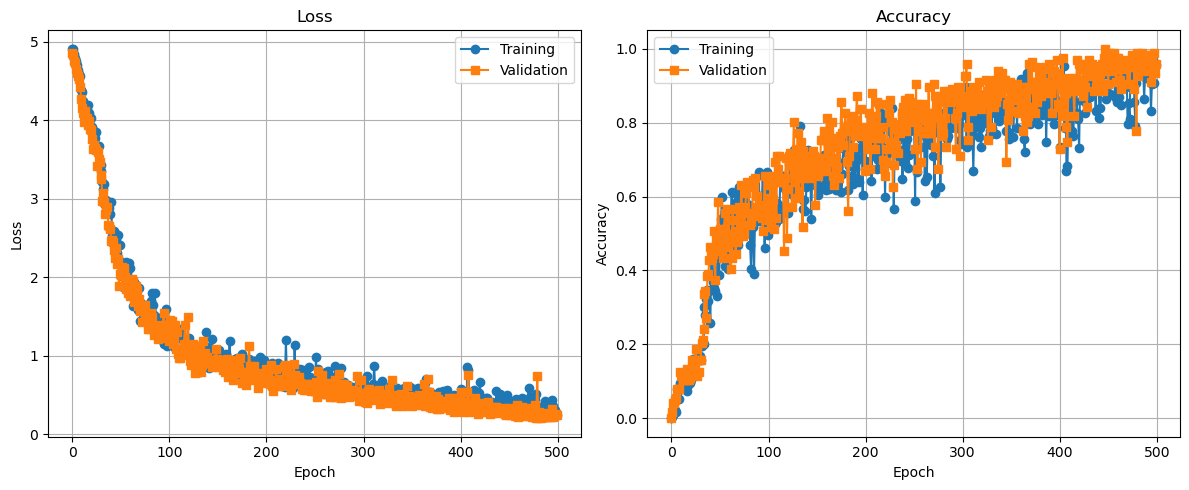

In [3]:
def plot_train_val_curves(history):
    """Plot training and validation curves for loss and accuracy"""
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], marker='o', label='Training')
    plt.plot(history['val_loss'], marker='s', label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], marker='o', label='Training')
    plt.plot(history['val_acc'], marker='s', label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# Create evaluation dataset
test_dataset = TensorDataset(x_enc_test, x_dec_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Plot training curves
plot_train_val_curves(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_token_level(model, src_data, tgt_data, vocab_tgt, device, pad_idx=PAD_IDX, max_display_labels=20):
    model.eval()
    y_true = []
    y_pred = []

    print("[EVAL] Starting evaluation over", len(src_data), "samples.")

    with torch.no_grad():
        for i in range(len(src_data)):
            src_seq = src_data[i].unsqueeze(0).to(device)
            tgt_seq = tgt_data[i].to(device)

            print(f"[EVAL] Sample {i} - Source shape:", src_seq.shape)
            print(f"[EVAL] Sample {i} - Target length:", tgt_seq.shape[0])

            # Get model prediction (includes <eos> if generated)
            pred_seq = model.translate(src_seq, max_len=tgt_seq.shape[0])[0]
            
            # Ground truth without <sos> but keeping <eos> and padding
            tgt_seq_content = tgt_seq[1:].cpu().numpy()  # Remove only <sos>
            pred_seq_content = pred_seq.cpu().numpy()
            
            # Pad predicted sequence to match ground truth length if needed
            if len(pred_seq_content) < len(tgt_seq_content):
                pred_seq_content = np.pad(
                    pred_seq_content,
                    (0, len(tgt_seq_content) - len(pred_seq_content)),
                    mode='constant',
                    constant_values=pad_idx
                )
            elif len(pred_seq_content) > len(tgt_seq_content):
                pred_seq_content = pred_seq_content[:len(tgt_seq_content)]
            
            print(f"[EVAL] Sample {i} - Predicted token IDs:", pred_seq_content.tolist())
            print(f"[EVAL] Sample {i} - Ground truth token IDs:", tgt_seq_content.tolist())

            # Compare up to the <eos> token in ground truth
            # Find the first <eos> in ground truth
            try:
                eos_pos = np.where(tgt_seq_content == END_IDX)[0][0]
                compare_len = eos_pos + 1  # include the <eos> token
            except IndexError:
                compare_len = len(tgt_seq_content)
            
            # Only compare up to compare_len
            for t, p in zip(tgt_seq_content[:compare_len], pred_seq_content[:compare_len]):
                if t != pad_idx:
                    y_true.append(t)
                    y_pred.append(p)

    print(f"[EVAL] Total non-pad tokens evaluated: {len(y_true)}")
    print("[EVAL] Sample decoded predictions vs targets (first 10):")
    for i in range(min(10, len(y_true))):
        print(f"  True: {vocab_tgt.get_itos()[y_true[i]]} ({y_true[i]}), Pred: {vocab_tgt.get_itos()[y_pred[i]]} ({y_pred[i]})")

    # Extract labels and names
    valid_labels = sorted(set(y_true + y_pred))
    target_names = [vocab_tgt.get_itos()[i] for i in valid_labels]

    print("\n[EVAL] Classification report:")
    print(classification_report(
        y_true, y_pred,
        labels=valid_labels,
        target_names=target_names,
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
    display_labels = valid_labels[:max_display_labels]
    cm_display = cm[:max_display_labels, :max_display_labels]
    display_names = [vocab_tgt.get_itos()[i] for i in display_labels]

    print(f"\n[EVAL] Displaying top {max_display_labels} tokens in confusion matrix.")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
                xticklabels=display_names, yticklabels=display_names)
    plt.title("Confusion Matrix (Top Tokens)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Assuming you have your model, test data, vocabulary, and device defined
# Example usage:
evaluate_token_level(model, x_enc_test, y_test, tgt_vocab, device, pad_idx=PAD_IDX)

[EVAL] Starting evaluation over 8 samples.
[EVAL] Sample 0 - Source shape: torch.Size([1, 39])
[EVAL] Sample 0 - Target length: 47
[EVAL] Sample 0 - Predicted token IDs: [106, 5, 117, 5, 81, 21, 15, 17, 19, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[EVAL] Sample 0 - Ground truth token IDs: [106, 5, 117, 5, 81, 21, 15, 17, 19, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[EVAL] Sample 1 - Source shape: torch.Size([1, 39])
[EVAL] Sample 1 - Target length: 47
[EVAL] Sample 1 - Predicted token IDs: [6, 4, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[EVAL] Sample 1 - Ground truth token IDs: [6, 4, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[EVAL] Sample 2 - Source shape: torch.Size(

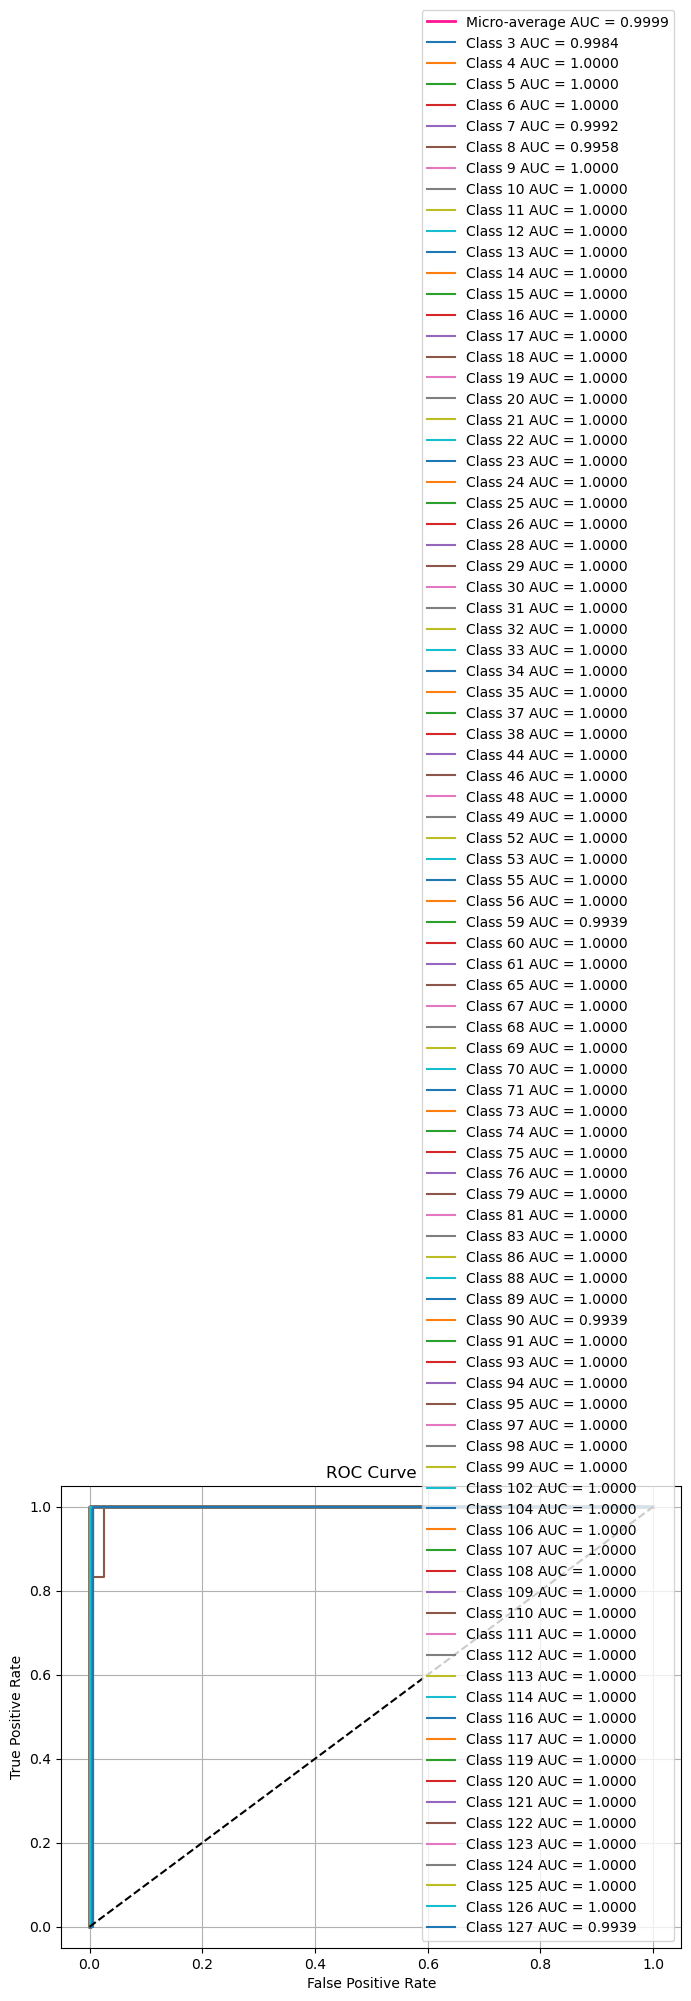

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import torch.nn.functional as F

def plot_roc_auc(model, data_loader, device, pad_idx):
    """Safe ROC AUC plot for multi-class seq2seq model"""
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for src, trg_in, trg_out in data_loader:
            src, trg_in, trg_out = src.to(device), trg_in.to(device), trg_out.to(device)
            outputs = model(src, trg_in)  # (batch, seq_len, vocab_size)
            probs = F.softmax(outputs, dim=-1)

            probs = probs[:, 1:].contiguous().view(-1, probs.size(-1))
            targets = trg_out[:, 1:].contiguous().view(-1)

            mask = targets != pad_idx
            probs = probs[mask]
            targets = targets[mask]

            all_probs.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_targets = np.concatenate(all_targets)

    # Check if at least two classes exist
    unique_classes = np.unique(all_targets)
    if len(unique_classes) < 2:
        print(f"[Warning] Only one class ({unique_classes[0]}) present in y_true. ROC AUC cannot be computed.")
        return

    num_classes = all_probs.shape[1]
    all_targets_bin = label_binarize(all_targets, classes=np.arange(num_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        if np.sum(all_targets_bin[:, i]) == 0:
            continue  # skip class not present in y_true
        fpr[i], tpr[i], _ = roc_curve(all_targets_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(all_targets_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average AUC = {roc_auc['micro']:.4f}", color='deeppink', linewidth=2)

    int_keys = sorted(k for k in roc_auc.keys() if isinstance(k, int))
    for i in int_keys:
        plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.4f}")


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_auc(model, test_loader, device, PAD_IDX)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_bleu(model, src_data, tgt_data, src_vocab, tgt_vocab, num_samples=15):
    model.eval()
    references = []
    hypotheses = []
    samples = []

    with torch.no_grad():
        for i in range(min(num_samples, len(src_data))):
            src_seq = src_data[i].unsqueeze(0).to(device)
            tgt_seq = tgt_data[i].to(device)

            # Get model prediction
            pred_seq = model.translate(src_seq, max_len=tgt_seq.shape[0])[0].tolist()
            
            # Process reference: Convert all tokens except padding
            ref_tokens = [idx.item() for idx in tgt_seq if idx.item() != PAD_IDX]
            
            # Process prediction: keep everything except padding
            pred_tokens = [t for t in pred_seq if t != PAD_IDX]
            
            # Convert to text
            def id_to_text(id_list, vocab):
                text = []
                for idx in id_list:
                    if idx == END_IDX:
                        text.append('<end>')
                    elif idx == START_IDX:
                        text.append('<sos>')
                    elif idx != PAD_IDX:
                        text.append(vocab.get_itos()[idx])
                return text
            
            ref_text = id_to_text(ref_tokens, tgt_vocab)
            pred_text = id_to_text(pred_tokens, tgt_vocab)
            src_text = id_to_text([idx.item() for idx in src_data[i] 
                                 if idx.item() != PAD_IDX], src_vocab)

            # For display: keep full sequence including <sos> and <end>
            display_ref = " ".join(ref_text)
            display_pred = " ".join(pred_text)
            
            # For BLEU calculation: remove special tokens
            ref_bleu = [t for t in ref_text if t not in ['<sos>', '<end>']]
            pred_bleu = [t for t in pred_text if t not in ['<sos>', '<end>']]
            
            references.append([ref_bleu])
            hypotheses.append(pred_bleu)

            # Store samples for display
            samples.append((" ".join(src_text), display_ref, display_pred))

    # Calculate BLEU with smoothing
    smoothie = SmoothingFunction().method4
    bleu = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    
    print(f"\nCorpus BLEU score: {bleu:.4f}")
    print("\nSample translations:")
    for i, (src, ref, hyp) in enumerate(samples):
        print(f"\nSample {i+1}")
        print(f"Source    : {src}")
        print(f"Reference : {ref}")
        print(f"Predicted : {hyp}")
        
        # Calculate individual BLEU score
        ref_tokens = ref.split()
        hyp_tokens = hyp.split()
        
        # Remove special tokens for BLEU calculation
        ref_for_bleu = [t for t in ref_tokens if t not in ['<sos>', '<end>']]
        hyp_for_bleu = [t for t in hyp_tokens if t not in ['<sos>', '<end>']]
        
        sample_bleu = corpus_bleu([[ref_for_bleu]], [hyp_for_bleu], smoothing_function=smoothie)
        print(f"BLEU for this sample: {sample_bleu:.4f}")

    return bleu

# Usage example
evaluate_bleu(model, x_enc_test, y_test, src_vocab, tgt_vocab)


Corpus BLEU score: 0.7666

Sample translations:

Sample 1
Source    : Ich bitte Sie , sich zu einer Schweigeminute zu erheben .
Reference : rise , then , for this minute' s silence . <end>
Predicted : rise , then , for this minute' s silence . <end>
BLEU for this sample: 1.0000

Sample 2
Source    : Wiederaufnahme der Sitzungsperiode
Reference : of the session <end>
Predicted : of the session <end>
BLEU for this sample: 1.0000

Sample 3
Source    : Frau Praesidentin , zur Geschaeftsordnung .
Reference : President , on a point of order . <end>
Predicted : President , on a point of order . <end>
BLEU for this sample: 1.0000

Sample 4
Source    : Wie Sie feststellen konnten , ist der gefuerchtete "Millenium - Bug " nicht eingetreten . Doch sind Buerger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden .
Reference : , as you will have seen , the dreaded 'millennium bug' failed to materialise , still the people in a number of countries suffered a series of 

0.7665958470658807


Evaluating Model...


[nltk_data] Downloading package punkt to /home/ardi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Classification Report for Each Token:
              precision    recall  f1-score   support

 'millennium       0.00      0.00      0.00       1.0
           (       0.00      0.00      0.00       1.0
           )       0.00      0.00      0.00       0.0
           ,       0.00      0.00      0.00      13.0
           -       0.00      0.00      0.00       1.0
           .       0.00      0.00      0.00       0.0
    Although       0.00      0.00      0.00       1.0
    European       0.00      0.00      0.00       1.0
       House       0.00      0.00      0.00       1.0
           I       0.00      0.00      0.00       1.0
          In       0.00      0.00      0.00       1.0
       Kumar       0.00      0.00      0.00       1.0
       Lanka       0.00      0.00      0.00       1.0
       Madam       0.00      0.00      0.00       1.0
     Members       0.00      0.00      0.00       1.0
          Mr       0.00      0.00      0.00       1.0
         One       0.00      0.00      0.0

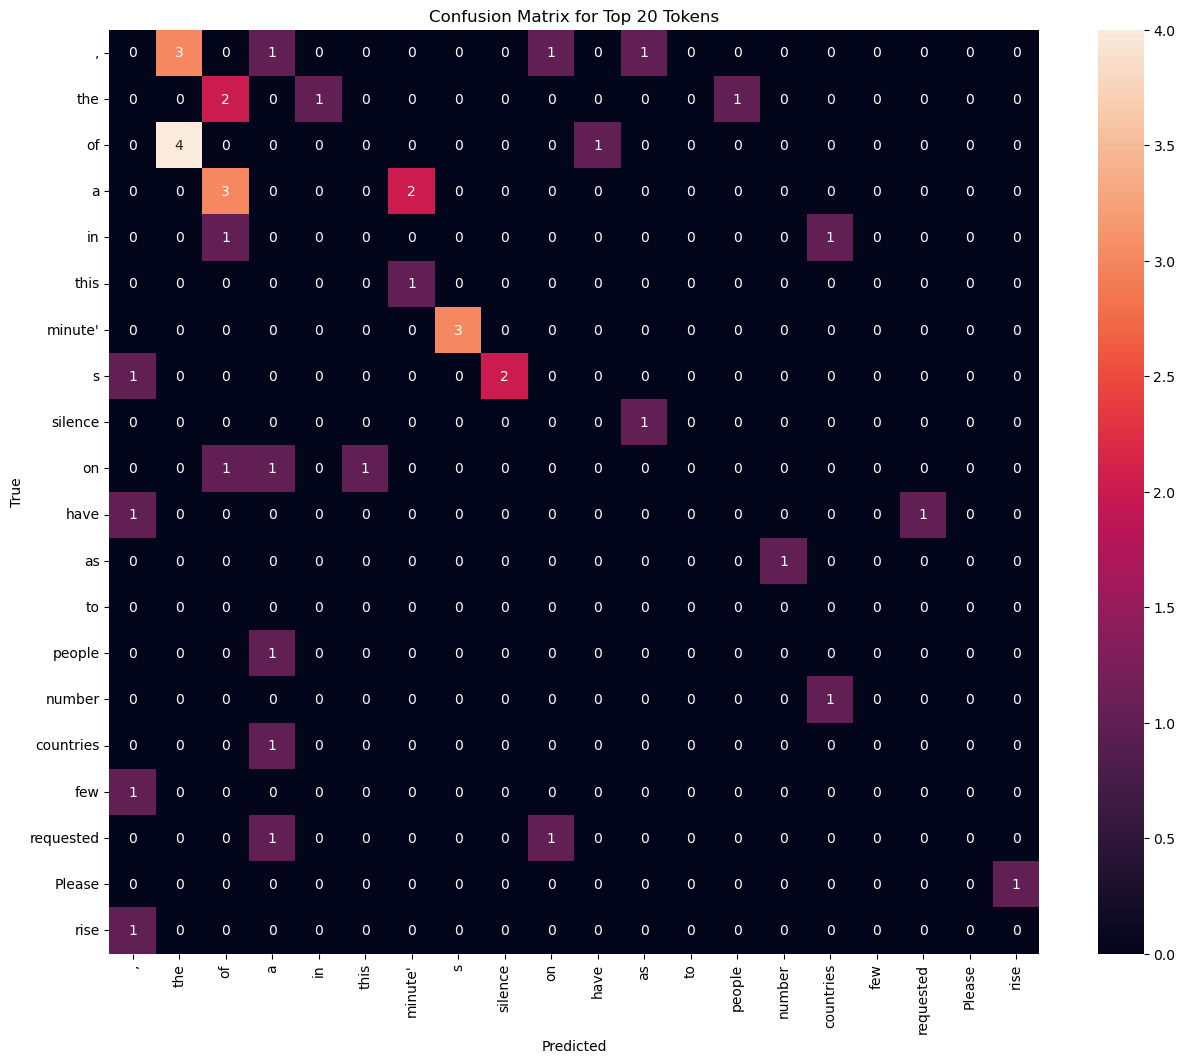


BLEU Score: 0.7270


In [ ]:
# ======================== Evaluation ========================
import nltk
from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

def evaluate_model(model, x_enc_test, y_test, tgt_vocab, device):
    model.eval()
    with torch.no_grad():
        # Move test data to device
        x_enc_test = x_enc_test.to(device)
        # Generate translations
        generated_indices = model.translate(x_enc_test)
        
    # Process predictions and references
    predicted_tokens_list = []
    true_tokens_list = []

    for i in range(len(x_enc_test)):
        # Process generated sequence
        gen_seq = generated_indices[i].cpu().numpy()
        pred_tokens = [tgt_vocab.lookup_token(idx) for idx in gen_seq]
        # Strip special tokens
        pred_tokens = [tok for tok in pred_tokens if tok not in ['<start>', '<end>']]
        # Remove tokens after <end>
        try:
            end_idx = pred_tokens.index('<end>')
            pred_tokens = pred_tokens[:end_idx]
        except ValueError:
            pass
        predicted_tokens_list.append(pred_tokens)

        # Process reference sequence
        ref_indices = y_test[i].cpu().numpy()
        ref_tokens = [tgt_vocab.lookup_token(idx) for idx in ref_indices]
        ref_filtered = []
        for tok in ref_tokens:
            if tok in ['<pad>', '<end>']:
                break
            ref_filtered.append(tok)
        true_tokens_list.append(ref_filtered)

    # Flatten and align tokens for classification report
    all_predicted = []
    all_true = []
    for pred, true in zip(predicted_tokens_list, true_tokens_list):
        min_len = min(len(pred), len(true))
        all_predicted.extend(pred[:min_len])
        all_true.extend(true[:min_len])

    # Classification report
    print("\nClassification Report for Each Token:")
    print(classification_report(all_true, all_predicted, zero_division=0))

    # Confusion matrix for top 20 tokens
    token_counts = Counter(all_true)
    top_tokens = [token for token, _ in token_counts.most_common(20)]
    
    # Filter pairs for confusion matrix
    cm_true = []
    cm_pred = []
    for t, p in zip(all_true, all_predicted):
        if t in top_tokens:
            cm_true.append(t)
            cm_pred.append(p if p in top_tokens else '<other>')

    # Generate confusion matrix
    cm = confusion_matrix(cm_true, cm_pred, labels=top_tokens)
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_tokens, yticklabels=top_tokens)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Top 20 Tokens')
    plt.show()

    # BLEU score calculation
    references = [[ref] for ref in true_tokens_list]
    hypotheses = predicted_tokens_list
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"\nBLEU Score: {bleu_score:.4f}")

# Run evaluation after training
print("\nEvaluating Model...")
evaluate_model(model, x_enc_test, y_test, tgt_vocab, device)